Model Independent Method to extract $c_i, s_i$ and $x_\pm, y_\pm$ from $D \to K_S^0 \pi^+ \pi^-$ decays.
===

We start by defining our binning scheme and binning the data


In [2]:
#Import necessary parts

import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import iminuit
import scipy.stats
import uproot


We take a "reference" sample, which we use `AmpGen` to print out ($m_-^2, m_+^2, \Delta \delta_D$) values as a `csv` file, called `reference.csv`. We use `getDD` to make this into a `DataFrame`, `refDD`.





In [3]:
def getDD(fileName):
    s01 = []
    s02 = []
    dd = []
    with open(fileName) as f:
        for line in f:
            a = line.split()
            _s01 = float(a[0])
            _s02 = float(a[1])
            _dd = float(a[3])
            s01.append(_s01)
            s02.append(_s02)
            dd.append(_dd)
    return pd.DataFrame({"s01":s01, "s02":s02, "dd":dd})
                        
refDD = getDD("reference.csv")

We can plot $\Delta \delta_D(m_-^2,m_+^2)$ from this, using `plotDD`

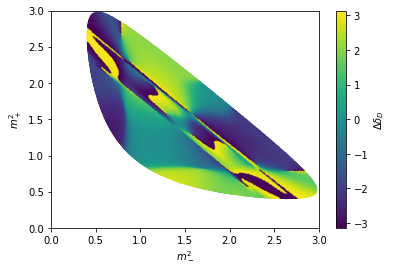

In [4]:
def plotDD(df, xlims=[0,3], ylims=[0,3]):
    x = df["s01"]
    y = df["s02"]
    z = df["dd"]
    f, a = plt.subplots(1,1)
    sc = a.scatter(x, y, c=z, s=0.01, marker="x")
    plt.xlim(xlims[0], xlims[1])
    plt.ylim(ylims[0], ylims[1])
    a.set_xlabel(r"$m_-^2$")
    a.set_ylabel(r"$m_+^2$")
    plt.colorbar(sc, ax=a, label=r"$\Delta \delta_D$")
    
    
plotDD(refDD)

We can define bins (using an equal binning scheme for $\Delta \delta_D$ using the `equalBinning` function, which takes the `refDD` `pandas.DataFrame` and selects the portion of `refDD` with $\Delta \delta_D$ inside bin $i$. 

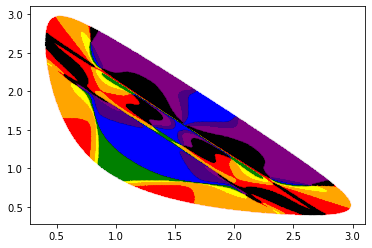

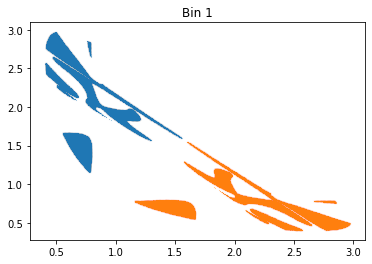

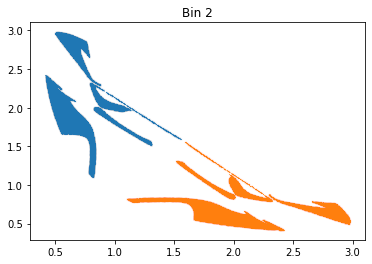

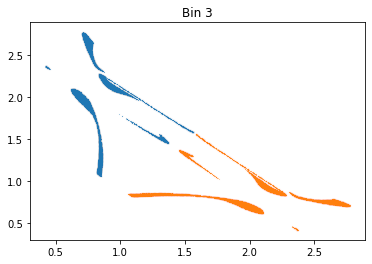

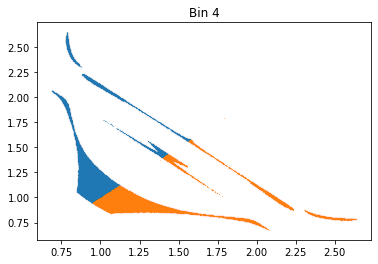

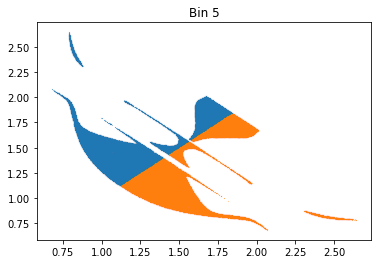

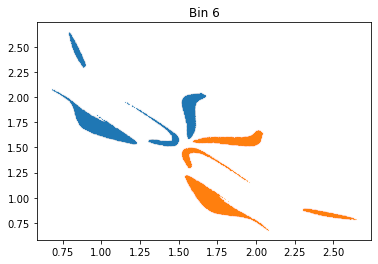

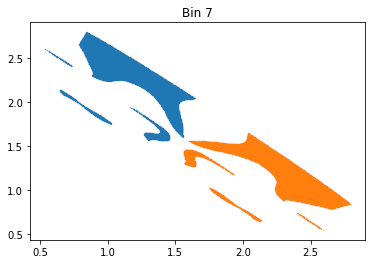

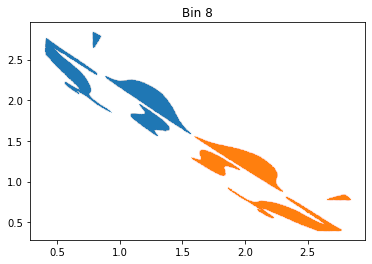

In [5]:
def equalBinning(df, i, j=1):

    if j>0:
        eqDD = np.linspace(-np.pi, np.pi, 9)

    

        s01_bins = {}
        s02_bins = {}
        dd_bins = {}
        #For bin 0

        dd = df["dd"]

        cond0 = df["dd"] > eqDD[i-1]
        cond1 = df["dd"] < eqDD[i]
        cond2 = df["s02"] >= df["s01"]
        

        dd0 = df[ cond0 & cond1 & cond2 ]
        
        return dd0
    else:
        eqDD = np.linspace(-np.pi, np.pi, 9)

   

        s01_bins = {}
        s02_bins = {}
        dd_bins = {}
        #For bin 0

        dd = df["dd"]

        cond0 = df["dd"] > eqDD[i-1]
        cond1 = df["dd"] < eqDD[i]
        cond2 = df["s02"] <= df["s01"]
        

        dd0 = df[ cond0 & cond1 & cond2 ]
        
        return dd0

f0, a0 = plt.subplots(1,1)
colors = "red orange yellow green blue indigo purple black".split()
for i in range(1,9):
    df_Bin_plus = equalBinning(refDD, i, 1)
    df_Bin_minus = equalBinning(refDD, 9-i, -1)

    f,a=plt.subplots(1,1)

    xp, yp, ddp = df_Bin_plus.T.values
    xm, ym, ddm = df_Bin_minus.T.values
    
    a.scatter(xp,yp, s=0.01, marker="x")
    a.scatter(xm,ym, s=0.01, marker="x")
    a0.scatter(xp,yp, s=0.01, marker="x", c=colors[i-1])
    a0.scatter(xm,ym, s=0.01, marker="x", c=colors[i-1])
    a.set_title(f"Bin {i}")



So we can make the `ref_bins`, a dictionary where each key is the bin and the entry is the `DataFrame` with the ($m_-^2$, $m_+^2$)'s that correspond to that bin.

In [6]:
def reference_eq_binning(fileName, number):
    df = getDD(fileName)
    output = {}

    s01, s02, dd = df["s01"], df["s02"], df["dd"]

    for i in range(1,number+1):
        ddip = equalBinning(df, i, 1)
        ddim = equalBinning(df, number+1-i, -1)
        output[f"{i}"] = ddip
        output[f"-{i}"] = ddim
    return output



ref_bins = reference_eq_binning("reference.csv", 8)
print(ref_bins)

{'1':              s01      s02       dd
0       0.702607  1.49052 -2.57581
3       1.036560  1.94265 -2.51693
7       0.507797  2.67124 -3.09377
22      0.612246  1.49246 -2.63681
27      0.761850  1.54603 -2.44030
...          ...      ...      ...
672377  0.794000  2.01902 -2.71518
672439  0.710423  1.40845 -2.63164
672441  0.607883  2.56525 -3.04257
672476  1.081550  1.82508 -3.12658
672479  0.445691  2.45585 -2.98285

[58633 rows x 3 columns], '-1':             s01       s02       dd
5       2.49245  0.714854  2.58003
13      1.59373  0.708169  2.45156
23      1.46274  0.763171  2.49449
45      1.51020  0.622789  2.60639
47      1.47749  0.659114  2.62372
...         ...       ...      ...
672400  2.06712  0.833956  2.52222
672417  1.99603  1.158330  3.05192
672418  1.60148  0.670091  2.45758
672459  2.32227  0.787040  2.41278
672477  1.62711  0.696165  2.40662

[58387 rows x 3 columns], '2':              s01      s02       dd
2       0.980660  2.01628 -1.97148
19      0.750515  2

Now we have $\Delta \delta_D$ in bins, we can obtain the mean value for $\cos(\Delta \delta_D)$ and $\sin(\Delta \delta_D)$, for each bin $i$


In [7]:
ci = {}
si = {}
for i in range(1,9):
    _ci, _si = 0,0
    ddp = ref_bins[f"{i}"]["dd"].values
    ddm = ref_bins[f"{-i}"]["dd"].values
    Np = len(ddp)
    Nm = len(ddm)
    N = Np + Nm
    for dd in ddp:
        _ci += np.cos(dd)
        _si += np.sin(dd)
    for dd in ddm:
        _ci += np.cos(dd)
        _si += -np.sin(dd)
        
        
    ci[f"{i}"] = _ci/N
    si[f"{i}"] = _si/N
    
    
print(f"i\tci\tsi")
for key in ci:
    print(f"{key}\t{round(ci[key], 3)}\t{round(si[key], 3)} ")
    

i	ci	si
1	-0.895	-0.376 
2	-0.374	-0.901 
3	0.301	-0.926 
4	0.948	-0.227 
5	0.932	0.283 
6	0.411	0.884 
7	-0.485	0.858 
8	-0.904	0.335 


So we now have a binning scheme (from our "reference" values), that is for each $(m_-^2,m_+^2)$ we can find a $i$. We can therefore take data samples (from a `root` file) which we generated via `AmpGen`, called `besiii_1.root` (for the correlated $D \to K_S^0 \pi^+ \pi^-$ data) and `BData.root` (for the simluated $B \to Dh$ amplitude). First we need to convert the `root` file to a `DataFrame`.

In [8]:
def getDalitz(fileName, tag):
    f = uproot.open(fileName)

    try:

        tSig = f[f"Signal_{tag}"]
        tTag = f[f"Tag_{tag}"]
    except:
        tSig = f[f"{tag}"]
        tTag = f[f"{tag}"]
    dalitz = {}

    sig_E1 = tSig.array("_1_K0S0_E")
    sig_E2 = tSig.array("_2_pi#_E")
    sig_E3 = tSig.array("_3_pi~_E")


    sig_Px1 = tSig.array("_1_K0S0_Px")
    sig_Px2 = tSig.array("_2_pi#_Px")
    sig_Px3 = tSig.array("_3_pi~_Px")

    sig_Py1 = tSig.array("_1_K0S0_Py")
    sig_Py2 = tSig.array("_2_pi#_Py")
    sig_Py3 = tSig.array("_3_pi~_Py")

    sig_Pz1 = tSig.array("_1_K0S0_Pz")
    sig_Pz2 = tSig.array("_2_pi#_Pz")
    sig_Pz3 = tSig.array("_3_pi~_Pz")

    sig_E12 = sig_E1 + sig_E2
    sig_E13 = sig_E1 + sig_E3

    sig_Px12 = sig_Px1 + sig_Px2
    sig_Px13 = sig_Px1 + sig_Px3

    sig_Py12 = sig_Py1 + sig_Py2
    sig_Py13 = sig_Py1 + sig_Py3

    sig_Pz12 = sig_Pz1 + sig_Pz2
    sig_Pz13 = sig_Pz1 + sig_Pz3

    sig_m12 = sig_E12**2 - sig_Px12**2 - sig_Py12**2 - sig_Pz12**2
    sig_m13 = sig_E13**2 - sig_Px13**2 - sig_Py13**2 - sig_Pz13**2
    
    dalitz["sig_m12"] = sig_m12
    dalitz["sig_m13"] = sig_m13
    

    if tag=="Kspipi":
        tag_E1 = tTag.array("_1_K0S0_E")
        tag_E2 = tTag.array("_2_pi#_E")
        tag_E3 = tTag.array("_3_pi~_E")


        tag_Px1 = tTag.array("_1_K0S0_Px")
        tag_Px2 = tTag.array("_2_pi#_Px")
        tag_Px3 = tTag.array("_3_pi~_Px")

        tag_Py1 = tTag.array("_1_K0S0_Py")
        tag_Py2 = tTag.array("_2_pi#_Py")
        tag_Py3 = tTag.array("_3_pi~_Py")

        tag_Pz1 = tTag.array("_1_K0S0_Pz")
        tag_Pz2 = tTag.array("_2_pi#_Pz")
        tag_Pz3 = tTag.array("_3_pi~_Pz")

        tag_E12 = tag_E1 + tag_E2
        tag_E13 = tag_E1 + tag_E3

        tag_Px12 = tag_Px1 + tag_Px2
        tag_Px13 = tag_Px1 + tag_Px3

        tag_Py12 = tag_Py1 + tag_Py2
        tag_Py13 = tag_Py1 + tag_Py3

        tag_Pz12 = tag_Pz1 + tag_Pz2
        tag_Pz13 = tag_Pz1 + tag_Pz3

        tag_m12 = tag_E12**2 - tag_Px12**2 - tag_Py12**2 - tag_Pz12**2
        tag_m13 = tag_E13**2 - tag_Px13**2 - tag_Py13**2 - tag_Pz13**2

        dalitz["tag_m12"] = tag_m12
        dalitz["tag_m13"] = tag_m13

    return pd.DataFrame(dalitz)
       
df_KK = getDalitz("besiii_1.root", "KK")
df_Kppim = getDalitz("besiii_1.root", "Kppim")
df_Kspi0 = getDalitz("besiii_1.root", "Kspi0")
df_Kspipi = getDalitz("besiii_1.root", "Kspipi")
df_Bp2Dhp = getDalitz("BData.root", "Bp2Dhp")
df_Bm2Dhm = getDalitz("BData.root", "Bm2Dhm")



data = {"KK":df_KK,
       "Kspi0":df_Kspi0,
       "Kppim":df_Kppim,
       "Kspipi":df_Kspipi,
       "Bp2Dhp":df_Bp2Dhp,
       "Bm2Dhm":df_Bm2Dhm
       }


To split this sample into bins, we use `getBin` that takes $(m_-^2,m_+^2)$ and assigns a $i$, where 
$i \equiv \min_i |\textbf{z} - \textbf{z}^\text{ref}_i|^2$

In [9]:
def getBin(x, y, bins):
    dists = []
    for key in bins:
        df = bins[key]
        X = df["s01"].values
        Y = df["s02"].values
        dX = X - x
        dY = Y - y
        dS = (dX**2 + dY**2)
        dists.append(min(dS))
        

   
    DF = pd.DataFrame(dists)
    idx = DF.idxmin()[0]
    b = 0
    if idx%2==0:
        b = int(0.5*idx+1)
    else : 
        b = int(-0.5*idx-0.5)
    return b

-4
-4
At 0% binning
At 1% binning
At 2% binning
At 3% binning
At 4% binning
At 5% binning
At 6% binning
At 7% binning
At 8% binning
At 9% binning
At 10% binning
At 11% binning
At 12% binning
At 13% binning
At 14% binning
At 15% binning
At 16% binning
At 17% binning
At 18% binning
At 19% binning
At 20% binning
At 21% binning
At 22% binning
At 23% binning
At 24% binning
At 25% binning
At 26% binning
At 27% binning
At 28% binning
At 29% binning
At 30% binning
At 31% binning
At 32% binning
At 33% binning
At 34% binning
At 35% binning
At 36% binning
At 37% binning
At 38% binning
At 39% binning
At 40% binning
At 41% binning
At 42% binning
At 43% binning
At 44% binning
At 45% binning
At 46% binning
At 47% binning
At 48% binning
At 49% binning
At 50% binning
At 51% binning
At 52% binning
At 53% binning
At 54% binning
At 55% binning
At 56% binning
At 57% binning
At 58% binning
At 59% binning
At 60% binning
At 61% binning
At 62% binning
At 63% binning
At 64% binning
At 65% binning
At 66% binning

At 520% binning
At 521% binning
At 522% binning
At 523% binning
At 524% binning
At 525% binning
At 526% binning
At 527% binning
At 528% binning
At 529% binning
At 530% binning
At 531% binning
At 532% binning
At 533% binning
At 534% binning
At 535% binning
At 536% binning
At 537% binning
At 538% binning
At 539% binning
At 540% binning
At 541% binning
At 542% binning
At 543% binning
At 544% binning
At 545% binning
At 546% binning
At 547% binning
At 548% binning
At 549% binning
At 550% binning
At 551% binning
At 552% binning
At 553% binning
At 554% binning
At 555% binning
At 556% binning
At 557% binning
At 558% binning
At 559% binning
At 560% binning
At 561% binning
At 562% binning
At 563% binning
At 564% binning
At 565% binning
At 566% binning
At 567% binning
At 568% binning
At 569% binning
At 570% binning
At 571% binning
At 572% binning
At 573% binning
At 574% binning
At 575% binning
At 576% binning
At 577% binning
At 578% binning
At 579% binning
At 580% binning
At 581% binning
At 582% 

At 1033% binning
At 1034% binning
At 1035% binning
At 1036% binning
At 1037% binning
At 1038% binning
At 1039% binning
At 1040% binning
At 1041% binning
At 1042% binning
At 1043% binning
At 1044% binning
At 1045% binning
At 1046% binning
At 1047% binning
At 1048% binning
At 1049% binning
At 1050% binning
At 1051% binning
At 1052% binning
At 1053% binning
At 1054% binning
At 1055% binning
At 1056% binning
At 1057% binning
At 1058% binning
At 1059% binning
At 1060% binning
At 1061% binning
At 1062% binning
At 1063% binning
At 1064% binning
At 1065% binning
At 1066% binning
At 1067% binning
At 1068% binning
At 1069% binning
At 1070% binning
At 1071% binning
At 1072% binning
At 1073% binning
At 1074% binning
At 1075% binning
At 1076% binning
At 1077% binning
At 1078% binning
At 1079% binning
At 1080% binning
At 1081% binning
At 1082% binning
At 1083% binning
At 1084% binning
At 1085% binning
At 1086% binning
At 1087% binning
At 1088% binning
At 1089% binning
At 1090% binning
At 1091% binni

At 1517% binning
At 1518% binning
At 1519% binning
At 1520% binning
At 1521% binning
At 1522% binning
At 1523% binning
At 1524% binning
At 1525% binning
At 1526% binning
At 1527% binning
At 1528% binning
At 1529% binning
At 1530% binning
At 1531% binning
At 1532% binning
At 1533% binning
At 1534% binning
At 1535% binning
At 1536% binning
At 1537% binning
At 1538% binning
At 1539% binning
At 1540% binning
At 1541% binning
At 1542% binning
At 1543% binning
At 1544% binning
At 1545% binning
At 1546% binning
At 1547% binning
At 1548% binning
At 1549% binning
At 1550% binning
At 1551% binning
At 1552% binning
At 1553% binning
At 1554% binning
At 1555% binning
At 1556% binning
At 1557% binning
At 1558% binning
At 1559% binning
At 1560% binning
At 1561% binning
At 1562% binning
At 1563% binning
At 1564% binning
At 1565% binning
At 1566% binning
At 1567% binning
At 1568% binning
At 1569% binning
At 1570% binning
At 1571% binning
At 1572% binning
At 1573% binning
At 1574% binning
At 1575% binni

At 2003% binning
At 2004% binning
At 2005% binning
At 2006% binning
At 2007% binning
At 2008% binning
At 2009% binning
At 2010% binning
At 2011% binning
At 2012% binning
At 2013% binning
At 2014% binning
At 2015% binning
At 2016% binning
At 2017% binning
At 2018% binning
At 2019% binning
At 2020% binning
At 2021% binning
At 2022% binning
At 2023% binning
At 2024% binning
At 2025% binning
At 2026% binning
At 2027% binning
At 2028% binning
At 2029% binning
At 2030% binning
At 2031% binning
At 2032% binning
At 2033% binning
At 2034% binning
At 2035% binning
At 2036% binning
At 2037% binning
At 2038% binning
At 2039% binning
At 2040% binning
At 2041% binning
At 2042% binning
At 2043% binning
At 2044% binning
At 2045% binning
At 2046% binning
At 2047% binning
At 2048% binning
At 2049% binning
At 2050% binning
At 2051% binning
At 2052% binning
At 2053% binning
At 2054% binning
At 2055% binning
At 2056% binning
At 2057% binning
At 2058% binning
At 2059% binning
At 2060% binning
At 2061% binni

At 2486% binning
At 2487% binning
At 2488% binning
At 2489% binning
At 2490% binning
At 2491% binning
At 2492% binning
At 2493% binning
At 2494% binning
At 2495% binning
At 2496% binning
At 2497% binning
At 2498% binning
At 2499% binning
At 2500% binning
At 2501% binning
At 2502% binning
At 2503% binning
At 2504% binning
At 2505% binning
At 2506% binning
At 2507% binning
At 2508% binning
At 2509% binning
At 2510% binning
At 2511% binning
At 2512% binning
At 2513% binning
At 2514% binning
At 2515% binning
At 2516% binning
At 2517% binning
At 2518% binning
At 2519% binning
At 2520% binning
At 2521% binning
At 2522% binning
At 2523% binning
At 2524% binning
At 2525% binning
At 2526% binning
At 2527% binning
At 0% binning
At 1% binning
At 2% binning
At 3% binning
At 4% binning
At 5% binning
At 6% binning
At 7% binning
At 8% binning
At 9% binning
At 10% binning
At 11% binning
At 12% binning
At 13% binning
At 14% binning
At 15% binning
At 16% binning
At 17% binning
At 18% binning
At 19% binn

At 477% binning
At 478% binning
At 479% binning
At 480% binning
At 481% binning
At 482% binning
At 483% binning
At 484% binning
At 485% binning
At 486% binning
At 487% binning
At 488% binning
At 489% binning
At 490% binning
At 491% binning
At 492% binning
At 493% binning
At 494% binning
At 495% binning
At 496% binning
At 497% binning
At 498% binning
At 499% binning
At 500% binning
At 501% binning
At 502% binning
At 503% binning
At 504% binning
At 505% binning
At 506% binning
At 507% binning
At 508% binning
At 509% binning
At 510% binning
At 511% binning
At 512% binning
At 513% binning
At 514% binning
At 515% binning
At 516% binning
At 517% binning
At 518% binning
At 519% binning
At 520% binning
At 521% binning
At 522% binning
At 523% binning
At 524% binning
At 525% binning
At 526% binning
At 527% binning
At 528% binning
At 529% binning
At 530% binning
At 531% binning
At 532% binning
At 533% binning
At 534% binning
At 535% binning
At 536% binning
At 537% binning
At 538% binning
At 539% 

At 991% binning
At 992% binning
At 993% binning
At 994% binning
At 995% binning
At 996% binning
At 997% binning
At 998% binning
At 999% binning
At 1000% binning
At 1001% binning
At 1002% binning
At 1003% binning
At 1004% binning
At 1005% binning
At 1006% binning
At 1007% binning
At 1008% binning
At 1009% binning
At 1010% binning
At 1011% binning
At 1012% binning
At 1013% binning
At 1014% binning
At 1015% binning
At 1016% binning
At 1017% binning
At 1018% binning
At 1019% binning
At 1020% binning
At 1021% binning
At 1022% binning
At 1023% binning
At 1024% binning
At 1025% binning
At 1026% binning
At 1027% binning
At 1028% binning
At 1029% binning
At 1030% binning
At 1031% binning
At 1032% binning
At 1033% binning
At 1034% binning
At 1035% binning
At 1036% binning
At 1037% binning
At 1038% binning
At 1039% binning
At 1040% binning
At 1041% binning
At 1042% binning
At 1043% binning
At 1044% binning
At 1045% binning
At 1046% binning
At 1047% binning
At 1048% binning
At 1049% binning
At 105

At 1474% binning
At 1475% binning
At 1476% binning
At 1477% binning
At 1478% binning
At 1479% binning
At 1480% binning
At 1481% binning
At 1482% binning
At 1483% binning
At 1484% binning
At 1485% binning
At 1486% binning
At 1487% binning
At 1488% binning
At 1489% binning
At 1490% binning
At 1491% binning
At 1492% binning
At 1493% binning
At 1494% binning
At 1495% binning
At 1496% binning
At 1497% binning
At 1498% binning
At 1499% binning
At 1500% binning
At 1501% binning
At 1502% binning
At 1503% binning
At 1504% binning
At 1505% binning
At 1506% binning
At 1507% binning
At 1508% binning
At 1509% binning
At 1510% binning
At 1511% binning
At 1512% binning
At 1513% binning
At 1514% binning
At 1515% binning
At 1516% binning
At 1517% binning
At 1518% binning
At 1519% binning
At 1520% binning
At 1521% binning
At 1522% binning
At 1523% binning
At 1524% binning
At 1525% binning
At 1526% binning
At 1527% binning
At 1528% binning
At 1529% binning
At 1530% binning
At 1531% binning
At 1532% binni

At 253% binning
At 254% binning
At 255% binning
At 256% binning
At 257% binning
At 258% binning
At 259% binning
At 260% binning
At 261% binning
At 262% binning
At 263% binning
At 264% binning
At 265% binning
At 266% binning
At 267% binning
At 268% binning
At 269% binning
At 270% binning
At 271% binning
At 272% binning
At 273% binning
At 274% binning
At 275% binning
At 276% binning
At 277% binning
At 278% binning
At 279% binning
At 280% binning
At 281% binning
At 282% binning
At 283% binning
At 284% binning
At 285% binning
At 286% binning
At 287% binning
At 288% binning
At 289% binning
At 290% binning
At 291% binning
At 292% binning
At 293% binning
At 294% binning
At 295% binning
At 296% binning
At 297% binning
At 298% binning
At 299% binning
At 300% binning
At 301% binning
At 302% binning
At 303% binning
At 304% binning
At 305% binning
At 306% binning
At 307% binning
At 308% binning
At 309% binning
At 310% binning
At 311% binning
At 312% binning
At 313% binning
At 314% binning
At 315% 

At 768% binning
At 769% binning
At 770% binning
At 771% binning
At 772% binning
At 773% binning
At 774% binning
At 775% binning
At 776% binning
At 777% binning
At 778% binning
At 779% binning
At 780% binning
At 781% binning
At 782% binning
At 783% binning
At 784% binning
At 785% binning
At 786% binning
At 787% binning
At 788% binning
At 789% binning
At 790% binning
At 791% binning
At 792% binning
At 793% binning
At 794% binning
At 795% binning
At 796% binning
At 797% binning
At 798% binning
At 799% binning
At 800% binning
At 801% binning
At 802% binning
At 803% binning
At 804% binning
At 805% binning
At 806% binning
At 807% binning
At 808% binning
At 809% binning
At 810% binning
At 811% binning
At 812% binning
At 813% binning
At 814% binning
At 815% binning
At 816% binning
At 817% binning
At 818% binning
At 819% binning
At 820% binning
At 821% binning
At 822% binning
At 823% binning
At 824% binning
At 825% binning
At 826% binning
At 827% binning
At 828% binning
At 829% binning
At 830% 

At 1268% binning
At 1269% binning
At 1270% binning
At 1271% binning
At 1272% binning
At 1273% binning
At 1274% binning
At 1275% binning
At 1276% binning
At 1277% binning
At 1278% binning
At 1279% binning
At 1280% binning
At 1281% binning
At 1282% binning
At 1283% binning
At 1284% binning
At 1285% binning
At 1286% binning
At 1287% binning
At 1288% binning
At 1289% binning
At 1290% binning
At 1291% binning
At 1292% binning
At 1293% binning
At 1294% binning
At 1295% binning
At 1296% binning
At 1297% binning
At 1298% binning
At 1299% binning
At 1300% binning
At 1301% binning
At 1302% binning
At 1303% binning
At 1304% binning
At 1305% binning
At 1306% binning
At 1307% binning
At 1308% binning
At 1309% binning
At 1310% binning
At 1311% binning
At 1312% binning
At 1313% binning
At 1314% binning
At 1315% binning
At 1316% binning
At 1317% binning
At 1318% binning
At 1319% binning
At 1320% binning
At 1321% binning
At 1322% binning
At 1323% binning
At 1324% binning
At 1325% binning
At 1326% binni

At 1753% binning
At 1754% binning
At 1755% binning
At 1756% binning
At 1757% binning
At 1758% binning
At 1759% binning
At 1760% binning
At 1761% binning
At 1762% binning
At 1763% binning
At 1764% binning
At 1765% binning
At 1766% binning
At 1767% binning
At 1768% binning
At 1769% binning
At 1770% binning
At 1771% binning
At 1772% binning
At 1773% binning
At 1774% binning
At 1775% binning
At 1776% binning
At 1777% binning
At 1778% binning
At 1779% binning
At 1780% binning
At 1781% binning
At 1782% binning
At 1783% binning
At 1784% binning
At 1785% binning
At 1786% binning
At 1787% binning
At 1788% binning
At 1789% binning
At 1790% binning
At 1791% binning
At 1792% binning
At 1793% binning
At 1794% binning
At 1795% binning
At 1796% binning
At 1797% binning
At 1798% binning
At 1799% binning
At 1800% binning
At 1801% binning
At 1802% binning
At 1803% binning
At 1804% binning
At 1805% binning
At 1806% binning
At 1807% binning
At 1808% binning
At 1809% binning
At 1810% binning
At 1811% binni

At 2238% binning
At 2239% binning
At 2240% binning
At 2241% binning
At 2242% binning
At 2243% binning
At 2244% binning
At 2245% binning
At 2246% binning
At 2247% binning
At 2248% binning
At 2249% binning
At 2250% binning
At 2251% binning
At 2252% binning
At 2253% binning
At 2254% binning
At 2255% binning
At 2256% binning
At 2257% binning
At 2258% binning
At 2259% binning
At 2260% binning
At 2261% binning
At 2262% binning
At 2263% binning
At 2264% binning
At 2265% binning
At 2266% binning
At 2267% binning
At 2268% binning
At 2269% binning
At 2270% binning
At 2271% binning
At 2272% binning
At 2273% binning
At 2274% binning
At 2275% binning
At 2276% binning
At 2277% binning
At 2278% binning
At 2279% binning
At 2280% binning
At 2281% binning
At 2282% binning
At 2283% binning
At 2284% binning
At 2285% binning
At 2286% binning
At 2287% binning
At 2288% binning
At 2289% binning
At 2290% binning
At 2291% binning
At 2292% binning
At 2293% binning
At 2294% binning
At 2295% binning
At 2296% binni

At 2723% binning
At 2724% binning
At 2725% binning
At 2726% binning
At 2727% binning
At 2728% binning
At 2729% binning
At 2730% binning
At 2731% binning
At 2732% binning
At 2733% binning
At 2734% binning
At 2735% binning
At 2736% binning
At 2737% binning
At 2738% binning
At 2739% binning
At 2740% binning
At 2741% binning
At 2742% binning
At 2743% binning
At 2744% binning
At 2745% binning
At 2746% binning
At 2747% binning
At 2748% binning
At 2749% binning
At 2750% binning
At 2751% binning
At 2752% binning
At 2753% binning
At 2754% binning
At 2755% binning
At 2756% binning
At 2757% binning
At 2758% binning
At 2759% binning
At 2760% binning
At 2761% binning
At 2762% binning
At 2763% binning
At 2764% binning
At 2765% binning
At 2766% binning
At 2767% binning
At 2768% binning
At 2769% binning
At 2770% binning
At 2771% binning
At 2772% binning
At 2773% binning
At 2774% binning
At 2775% binning
At 2776% binning
At 2777% binning
At 2778% binning
At 2779% binning
At 2780% binning
At 2781% binni

At 3208% binning
At 3209% binning
At 3210% binning
At 3211% binning
At 3212% binning
At 3213% binning
At 3214% binning
At 3215% binning
At 3216% binning
At 3217% binning
At 3218% binning
At 3219% binning
At 3220% binning
At 3221% binning
At 3222% binning
At 3223% binning
At 3224% binning
At 3225% binning
At 3226% binning
At 3227% binning
At 3228% binning
At 3229% binning
At 3230% binning
At 3231% binning
At 3232% binning
At 3233% binning
At 3234% binning
At 3235% binning
At 3236% binning
At 3237% binning
At 3238% binning
At 3239% binning
At 3240% binning
At 3241% binning
At 3242% binning
At 3243% binning
At 3244% binning
At 3245% binning
At 3246% binning
At 3247% binning
At 3248% binning
At 3249% binning
At 3250% binning
At 3251% binning
At 3252% binning
At 3253% binning
At 3254% binning
At 3255% binning
At 3256% binning
At 3257% binning
At 3258% binning
At 3259% binning
At 3260% binning
At 3261% binning
At 3262% binning
At 3263% binning
At 3264% binning
At 3265% binning
At 3266% binni

At 3694% binning
At 3695% binning
At 3696% binning
At 3697% binning
At 3698% binning
At 3699% binning
At 3700% binning
At 3701% binning
At 3702% binning
At 3703% binning
At 3704% binning
At 3705% binning
At 3706% binning
At 3707% binning
At 3708% binning
At 3709% binning
At 3710% binning
At 3711% binning
At 3712% binning
At 3713% binning
At 3714% binning
At 3715% binning
At 3716% binning
At 3717% binning
At 3718% binning
At 3719% binning
At 3720% binning
At 3721% binning
At 3722% binning
At 3723% binning
At 3724% binning
At 3725% binning
At 3726% binning
At 3727% binning
At 3728% binning
At 3729% binning
At 3730% binning
At 3731% binning
At 3732% binning
At 3733% binning
At 3734% binning
At 3735% binning
At 3736% binning
At 3737% binning
At 3738% binning
At 3739% binning
At 3740% binning
At 3741% binning
At 3742% binning
At 3743% binning
At 3744% binning
At 3745% binning
At 3746% binning
At 3747% binning
At 3748% binning
At 3749% binning
At 3750% binning
At 3751% binning
At 3752% binni

At 4180% binning
At 4181% binning
At 4182% binning
At 4183% binning
At 4184% binning
At 4185% binning
At 4186% binning
At 4187% binning
At 4188% binning
At 4189% binning
At 4190% binning
At 4191% binning
At 4192% binning
At 4193% binning
At 4194% binning
At 4195% binning
At 4196% binning
At 4197% binning
At 4198% binning
At 4199% binning
At 4200% binning
At 4201% binning
At 4202% binning
At 4203% binning
At 4204% binning
At 4205% binning
At 4206% binning
At 4207% binning
At 4208% binning
At 4209% binning
At 4210% binning
At 4211% binning
At 4212% binning
At 4213% binning
At 4214% binning
At 4215% binning
At 4216% binning
At 4217% binning
At 4218% binning
At 4219% binning
At 4220% binning
At 4221% binning
At 4222% binning
At 4223% binning
At 4224% binning
At 4225% binning
At 4226% binning
At 4227% binning
At 4228% binning
At 4229% binning
At 4230% binning
At 4231% binning
At 4232% binning
At 4233% binning
At 4234% binning
At 4235% binning
At 4236% binning
At 4237% binning
At 4238% binni

At 4665% binning
At 4666% binning
At 4667% binning
At 4668% binning
At 4669% binning
At 4670% binning
At 4671% binning
At 4672% binning
At 4673% binning
At 4674% binning
At 4675% binning
At 4676% binning
At 4677% binning
At 4678% binning
At 4679% binning
At 4680% binning
At 4681% binning
At 4682% binning
At 4683% binning
At 4684% binning
At 4685% binning
At 4686% binning
At 4687% binning
At 4688% binning
At 4689% binning
At 4690% binning
At 4691% binning
At 4692% binning
At 4693% binning
At 4694% binning
At 4695% binning
At 4696% binning
At 4697% binning
At 4698% binning
At 4699% binning
At 4700% binning
At 4701% binning
At 4702% binning
At 4703% binning
At 4704% binning
At 4705% binning
At 4706% binning
At 4707% binning
At 4708% binning
At 4709% binning
At 4710% binning
At 4711% binning
At 4712% binning
At 4713% binning
At 4714% binning
At 4715% binning
At 4716% binning
At 4717% binning
At 4718% binning
At 4719% binning
At 4720% binning
At 4721% binning
At 4722% binning
At 4723% binni

At 5150% binning
At 5151% binning
At 5152% binning
At 5153% binning
At 5154% binning
At 5155% binning
At 5156% binning
At 5157% binning
At 5158% binning
At 5159% binning
At 5160% binning
At 5161% binning
At 5162% binning
At 5163% binning
At 5164% binning
At 5165% binning
At 5166% binning
At 5167% binning
At 5168% binning
At 5169% binning
At 5170% binning
At 5171% binning
At 5172% binning
At 5173% binning
At 5174% binning
At 5175% binning
At 5176% binning
At 5177% binning
At 5178% binning
At 5179% binning
At 5180% binning
At 5181% binning
At 5182% binning
At 5183% binning
At 5184% binning
At 5185% binning
At 5186% binning
At 5187% binning
At 5188% binning
At 5189% binning
At 5190% binning
At 5191% binning
At 5192% binning
At 5193% binning
At 5194% binning
At 5195% binning
At 5196% binning
At 5197% binning
At 5198% binning
At 5199% binning
At 5200% binning
At 5201% binning
At 5202% binning
At 5203% binning
At 5204% binning
At 5205% binning
At 5206% binning
At 5207% binning
At 5208% binni

At 5635% binning
At 5636% binning
At 5637% binning
At 5638% binning
At 5639% binning
At 5640% binning
At 5641% binning
At 5642% binning
At 5643% binning
At 5644% binning
At 5645% binning
At 5646% binning
At 5647% binning
At 5648% binning
At 5649% binning
At 5650% binning
At 5651% binning
At 5652% binning
At 5653% binning
At 5654% binning
At 5655% binning
At 5656% binning
At 5657% binning
At 5658% binning
At 5659% binning
At 5660% binning
At 5661% binning
At 5662% binning
At 5663% binning
At 5664% binning
At 5665% binning
At 5666% binning
At 5667% binning
At 5668% binning
At 5669% binning
At 5670% binning
At 5671% binning
At 5672% binning
At 5673% binning
At 5674% binning
At 5675% binning
At 5676% binning
At 5677% binning
At 5678% binning
At 5679% binning
At 5680% binning
At 5681% binning
At 5682% binning
At 5683% binning
At 5684% binning
At 5685% binning
At 5686% binning
At 5687% binning
At 5688% binning
At 5689% binning
At 5690% binning
At 5691% binning
At 5692% binning
At 5693% binni

At 6121% binning
At 6122% binning
At 6123% binning
At 6124% binning
At 6125% binning
At 6126% binning
At 6127% binning
At 6128% binning
At 6129% binning
At 6130% binning
At 6131% binning
At 6132% binning
At 6133% binning
At 6134% binning
At 6135% binning
At 6136% binning
At 6137% binning
At 6138% binning
At 6139% binning
At 6140% binning
At 6141% binning
At 6142% binning
At 6143% binning
At 6144% binning
At 6145% binning
At 6146% binning
At 6147% binning
At 6148% binning
At 6149% binning
At 6150% binning
At 6151% binning
At 6152% binning
At 6153% binning
At 6154% binning
At 6155% binning
At 6156% binning
At 6157% binning
At 6158% binning
At 6159% binning
At 6160% binning
At 6161% binning
At 6162% binning
At 6163% binning
At 6164% binning
At 6165% binning
At 6166% binning
At 6167% binning
At 6168% binning
At 6169% binning
At 6170% binning
At 6171% binning
At 6172% binning
At 6173% binning
At 6174% binning
At 6175% binning
At 6176% binning
At 6177% binning
At 6178% binning
At 6179% binni

At 6605% binning
At 6606% binning
At 6607% binning
At 6608% binning
At 6609% binning
At 6610% binning
At 6611% binning
At 6612% binning
At 6613% binning
At 6614% binning
At 6615% binning
At 6616% binning
At 6617% binning
At 6618% binning
At 6619% binning
At 6620% binning
At 6621% binning
At 6622% binning
At 6623% binning
At 6624% binning
At 6625% binning
At 6626% binning
At 6627% binning
At 6628% binning
At 6629% binning
At 6630% binning
At 6631% binning
At 6632% binning
At 6633% binning
At 6634% binning
At 6635% binning
At 6636% binning
At 6637% binning
At 6638% binning
At 6639% binning
At 6640% binning
At 6641% binning
At 6642% binning
At 6643% binning
At 6644% binning
At 6645% binning
At 6646% binning
At 6647% binning
At 6648% binning
At 6649% binning
At 6650% binning
At 6651% binning
At 6652% binning
At 6653% binning
At 6654% binning
At 6655% binning
At 6656% binning
At 6657% binning
At 6658% binning
At 6659% binning
At 6660% binning
At 6661% binning
At 6662% binning
At 6663% binni

At 7090% binning
At 7091% binning
At 7092% binning
At 7093% binning
At 7094% binning
At 7095% binning
At 7096% binning
At 7097% binning
At 7098% binning
At 7099% binning
At 7100% binning
At 7101% binning
At 7102% binning
At 7103% binning
At 7104% binning
At 7105% binning
At 7106% binning
At 7107% binning
At 7108% binning
At 7109% binning
At 7110% binning
At 7111% binning
At 7112% binning
At 7113% binning
At 7114% binning
At 7115% binning
At 7116% binning
At 7117% binning
At 7118% binning
At 7119% binning
At 7120% binning
At 7121% binning
At 7122% binning
At 7123% binning
At 7124% binning
At 7125% binning
At 7126% binning
At 7127% binning
At 7128% binning
At 7129% binning
At 7130% binning
At 7131% binning
At 7132% binning
At 7133% binning
At 7134% binning
At 7135% binning
At 7136% binning
At 7137% binning
At 7138% binning
At 7139% binning
At 7140% binning
At 7141% binning
At 7142% binning
At 7143% binning
At 7144% binning
At 7145% binning
At 7146% binning
At 7147% binning
At 7148% binni

At 7575% binning
At 7576% binning
At 7577% binning
At 7578% binning
At 7579% binning
At 7580% binning
At 7581% binning
At 7582% binning
At 7583% binning
At 7584% binning
At 7585% binning
At 7586% binning
At 7587% binning
At 7588% binning
At 7589% binning
At 7590% binning
At 7591% binning
At 7592% binning
At 7593% binning
At 7594% binning
At 7595% binning
At 7596% binning
At 7597% binning
At 7598% binning
At 7599% binning
At 7600% binning
At 7601% binning
At 7602% binning
At 7603% binning
At 7604% binning
At 7605% binning
At 7606% binning
At 7607% binning
At 7608% binning
At 7609% binning
At 7610% binning
At 7611% binning
At 7612% binning
At 7613% binning
At 7614% binning
At 7615% binning
At 7616% binning
At 7617% binning
At 7618% binning
At 7619% binning
At 7620% binning
At 7621% binning
At 7622% binning
At 7623% binning
At 7624% binning
At 7625% binning
At 7626% binning
At 7627% binning
At 7628% binning
At 7629% binning
At 7630% binning
At 7631% binning
At 7632% binning
At 7633% binni

At 8058% binning
At 8059% binning
At 8060% binning
At 8061% binning
At 8062% binning
At 8063% binning
At 8064% binning
At 8065% binning
At 8066% binning
At 8067% binning
At 8068% binning
At 8069% binning
At 8070% binning
At 8071% binning
At 8072% binning
At 8073% binning
At 8074% binning
At 8075% binning
At 8076% binning
At 8077% binning
At 8078% binning
At 8079% binning
At 8080% binning
At 8081% binning
At 8082% binning
At 8083% binning
At 8084% binning
At 8085% binning
At 8086% binning
At 8087% binning
At 8088% binning
At 8089% binning
At 8090% binning
At 8091% binning
At 8092% binning
At 8093% binning
At 8094% binning
At 8095% binning
At 8096% binning
At 8097% binning
At 8098% binning
At 8099% binning
At 8100% binning
At 8101% binning
At 8102% binning
At 8103% binning
At 8104% binning
At 8105% binning
At 8106% binning
At 8107% binning
At 8108% binning
At 8109% binning
At 8110% binning
At 8111% binning
At 8112% binning
At 8113% binning
At 8114% binning
At 8115% binning
At 8116% binni

At 8543% binning
At 8544% binning
At 8545% binning
At 8546% binning
At 8547% binning
At 8548% binning
At 8549% binning
At 8550% binning
At 8551% binning
At 8552% binning
At 8553% binning
At 8554% binning
At 8555% binning
At 8556% binning
At 8557% binning
At 8558% binning
At 8559% binning
At 8560% binning
At 8561% binning
At 8562% binning
At 8563% binning
At 8564% binning
At 8565% binning
At 8566% binning
At 8567% binning
At 8568% binning
At 8569% binning
At 8570% binning
At 8571% binning
At 8572% binning
At 8573% binning
At 8574% binning
At 8575% binning
At 8576% binning
At 8577% binning
At 8578% binning
At 8579% binning
At 8580% binning
At 8581% binning
At 8582% binning
At 8583% binning
At 8584% binning
At 8585% binning
At 8586% binning
At 8587% binning
At 8588% binning
At 8589% binning
At 8590% binning
At 8591% binning
At 8592% binning
At 8593% binning
At 8594% binning
At 8595% binning
At 8596% binning
At 8597% binning
At 8598% binning
At 8599% binning
At 8600% binning
At 8601% binni

At 9027% binning
At 9028% binning
At 9029% binning
At 9030% binning
At 9031% binning
At 9032% binning
At 9033% binning
At 9034% binning
At 9035% binning
At 9036% binning
At 9037% binning
At 9038% binning
At 9039% binning
At 9040% binning
At 9041% binning
At 9042% binning
At 9043% binning
At 9044% binning
At 9045% binning
At 9046% binning
At 9047% binning
At 9048% binning
At 9049% binning
At 9050% binning
At 9051% binning
At 9052% binning
At 9053% binning
At 9054% binning
At 9055% binning
At 9056% binning
At 9057% binning
At 9058% binning
At 9059% binning
At 9060% binning
At 9061% binning
At 9062% binning
At 9063% binning
At 9064% binning
At 9065% binning
At 9066% binning
At 9067% binning
At 9068% binning
At 9069% binning
At 9070% binning
At 9071% binning
At 9072% binning
At 9073% binning
At 9074% binning
At 9075% binning
At 9076% binning
At 9077% binning
At 9078% binning
At 9079% binning
At 9080% binning
At 9081% binning
At 9082% binning
At 9083% binning
At 9084% binning
At 9085% binni

At 9511% binning
At 9512% binning
At 9513% binning
At 9514% binning
At 9515% binning
At 9516% binning
At 9517% binning
At 9518% binning
At 9519% binning
At 9520% binning
At 9521% binning
At 9522% binning
At 9523% binning
At 9524% binning
At 9525% binning
At 9526% binning
At 9527% binning
At 9528% binning
At 9529% binning
At 9530% binning
At 9531% binning
At 9532% binning
At 9533% binning
At 9534% binning
At 9535% binning
At 9536% binning
At 9537% binning
At 9538% binning
At 9539% binning
At 9540% binning
At 9541% binning
At 9542% binning
At 9543% binning
At 9544% binning
At 9545% binning
At 9546% binning
At 9547% binning
At 9548% binning
At 9549% binning
At 9550% binning
At 9551% binning
At 9552% binning
At 9553% binning
At 9554% binning
At 9555% binning
At 9556% binning
At 9557% binning
At 9558% binning
At 9559% binning
At 9560% binning
At 9561% binning
At 9562% binning
At 9563% binning
At 9564% binning
At 9565% binning
At 9566% binning
At 9567% binning
At 9568% binning
At 9569% binni

At 9994% binning
At 9995% binning
At 9996% binning
At 9997% binning
At 9998% binning
At 9999% binning
At 10000% binning
At 10001% binning
At 10002% binning
At 10003% binning
At 10004% binning
At 10005% binning
At 10006% binning
At 10007% binning
At 10008% binning
At 10009% binning
At 10010% binning
At 10011% binning
At 10012% binning
At 10013% binning
At 10014% binning
At 10015% binning
At 10016% binning
At 10017% binning
At 10018% binning
At 10019% binning
At 10020% binning
At 10021% binning
At 10022% binning
At 10023% binning
At 10024% binning
At 10025% binning
At 10026% binning
At 10027% binning
At 10028% binning
At 10029% binning
At 10030% binning
At 10031% binning
At 10032% binning
At 10033% binning
At 10034% binning
At 10035% binning
At 10036% binning
At 10037% binning
At 10038% binning
At 10039% binning
At 10040% binning
At 10041% binning
At 10042% binning
At 10043% binning
At 10044% binning
At 10045% binning
At 10046% binning
At 10047% binning
At 10048% binning
At 10049% binnin

At 10452% binning
At 10453% binning
At 10454% binning
At 10455% binning
At 10456% binning
At 10457% binning
At 10458% binning
At 10459% binning
At 10460% binning
At 10461% binning
At 10462% binning
At 10463% binning
At 10464% binning
At 10465% binning
At 10466% binning
At 10467% binning
At 10468% binning
At 10469% binning
At 10470% binning
At 10471% binning
At 10472% binning
At 10473% binning
At 10474% binning
At 10475% binning
At 10476% binning
At 10477% binning
At 10478% binning
At 10479% binning
At 10480% binning
At 10481% binning
At 10482% binning
At 10483% binning
At 10484% binning
At 10485% binning
At 10486% binning
At 10487% binning
At 10488% binning
At 10489% binning
At 10490% binning
At 10491% binning
At 10492% binning
At 10493% binning
At 10494% binning
At 10495% binning
At 10496% binning
At 10497% binning
At 10498% binning
At 10499% binning
At 10500% binning
At 10501% binning
At 10502% binning
At 10503% binning
At 10504% binning
At 10505% binning
At 10506% binning
At 10507% 

At 10912% binning
At 10913% binning
At 10914% binning
At 10915% binning
At 10916% binning
At 10917% binning
At 10918% binning
At 10919% binning
At 10920% binning
At 10921% binning
At 10922% binning
At 10923% binning
At 10924% binning
At 10925% binning
At 10926% binning
At 10927% binning
At 10928% binning
At 10929% binning
At 10930% binning
At 10931% binning
At 10932% binning
At 10933% binning
At 10934% binning
At 10935% binning
At 10936% binning
At 10937% binning
At 10938% binning
At 10939% binning
At 10940% binning
At 10941% binning
At 10942% binning
At 10943% binning
At 10944% binning
At 10945% binning
At 10946% binning
At 10947% binning
At 10948% binning
At 10949% binning
At 10950% binning
At 10951% binning
At 10952% binning
At 10953% binning
At 10954% binning
At 10955% binning
At 10956% binning
At 10957% binning
At 10958% binning
At 10959% binning
At 10960% binning
At 10961% binning
At 10962% binning
At 10963% binning
At 10964% binning
At 10965% binning
At 10966% binning
At 10967% 

At 11368% binning
At 11369% binning
At 11370% binning
At 11371% binning
At 11372% binning
At 11373% binning
At 11374% binning
At 11375% binning
At 11376% binning
At 11377% binning
At 11378% binning
At 11379% binning
At 11380% binning
At 11381% binning
At 11382% binning
At 11383% binning
At 11384% binning
At 11385% binning
At 11386% binning
At 11387% binning
At 11388% binning
At 11389% binning
At 11390% binning
At 11391% binning
At 11392% binning
At 11393% binning
At 11394% binning
At 11395% binning
At 11396% binning
At 11397% binning
At 11398% binning
At 11399% binning
At 11400% binning
At 11401% binning
At 11402% binning
At 11403% binning
At 11404% binning
At 11405% binning
At 11406% binning
At 11407% binning
At 11408% binning
At 11409% binning
At 11410% binning
At 11411% binning
At 11412% binning
At 11413% binning
At 11414% binning
At 11415% binning
At 11416% binning
At 11417% binning
At 11418% binning
At 11419% binning
At 11420% binning
At 11421% binning
At 11422% binning
At 11423% 

At 11827% binning
At 11828% binning
At 11829% binning
At 11830% binning
At 11831% binning
At 11832% binning
At 11833% binning
At 11834% binning
At 11835% binning
At 11836% binning
At 11837% binning
At 11838% binning
At 11839% binning
At 11840% binning
At 11841% binning
At 11842% binning
At 11843% binning
At 11844% binning
At 11845% binning
At 11846% binning
At 11847% binning
At 11848% binning
At 11849% binning
At 11850% binning
At 11851% binning
At 11852% binning
At 11853% binning
At 11854% binning
At 11855% binning
At 11856% binning
At 11857% binning
At 11858% binning
At 11859% binning
At 11860% binning
At 11861% binning
At 11862% binning
At 11863% binning
At 11864% binning
At 11865% binning
At 11866% binning
At 11867% binning
At 11868% binning
At 11869% binning
At 11870% binning
At 11871% binning
At 11872% binning
At 11873% binning
At 11874% binning
At 11875% binning
At 11876% binning
At 11877% binning
At 11878% binning
At 11879% binning
At 11880% binning
At 11881% binning
At 11882% 

At 12286% binning
At 12287% binning
At 12288% binning
At 12289% binning
At 12290% binning
At 12291% binning
At 12292% binning
At 12293% binning
At 12294% binning
At 12295% binning
At 12296% binning
At 12297% binning
At 12298% binning
At 12299% binning
At 12300% binning
At 12301% binning
At 12302% binning
At 12303% binning
At 12304% binning
At 12305% binning
At 12306% binning
At 12307% binning
At 12308% binning
At 12309% binning
At 12310% binning
At 12311% binning
At 12312% binning
At 12313% binning
At 12314% binning
At 12315% binning
At 12316% binning
At 12317% binning
At 12318% binning
At 12319% binning
At 12320% binning
At 12321% binning
At 12322% binning
At 12323% binning
At 12324% binning
At 12325% binning
At 12326% binning
At 12327% binning
At 12328% binning
At 12329% binning
At 12330% binning
At 12331% binning
At 12332% binning
At 12333% binning
At 12334% binning
At 12335% binning
At 12336% binning
At 12337% binning
At 12338% binning
At 12339% binning
At 12340% binning
At 12341% 

At 12746% binning
At 12747% binning
At 12748% binning
At 12749% binning
At 12750% binning
At 12751% binning
At 12752% binning
At 12753% binning
At 12754% binning
At 12755% binning
At 12756% binning
At 12757% binning
At 12758% binning
At 12759% binning
At 12760% binning
At 12761% binning
At 12762% binning
At 12763% binning
At 12764% binning
At 12765% binning
At 12766% binning
At 12767% binning
At 12768% binning
At 12769% binning
At 12770% binning
At 12771% binning
At 12772% binning
At 12773% binning
At 12774% binning
At 12775% binning
At 12776% binning
At 12777% binning
At 12778% binning
At 12779% binning
At 12780% binning
At 12781% binning
At 12782% binning
At 12783% binning
At 12784% binning
At 12785% binning
At 12786% binning
At 12787% binning
At 12788% binning
At 12789% binning
At 12790% binning
At 12791% binning
At 12792% binning
At 12793% binning
At 12794% binning
At 12795% binning
At 12796% binning
At 12797% binning
At 12798% binning
At 12799% binning
At 12800% binning
At 12801% 

At 13206% binning
At 13207% binning
At 13208% binning
At 13209% binning
At 13210% binning
At 13211% binning
At 13212% binning
At 13213% binning
At 13214% binning
At 13215% binning
At 13216% binning
At 13217% binning
At 13218% binning
At 13219% binning
At 13220% binning
At 13221% binning
At 13222% binning
At 13223% binning
At 13224% binning
At 13225% binning
At 13226% binning
At 13227% binning
At 13228% binning
At 13229% binning
At 13230% binning
At 13231% binning
At 13232% binning
At 13233% binning
At 13234% binning
At 13235% binning
At 13236% binning
At 13237% binning
At 13238% binning
At 13239% binning
At 13240% binning
At 13241% binning
At 13242% binning
At 13243% binning
At 13244% binning
At 13245% binning
At 13246% binning
At 13247% binning
At 13248% binning
At 13249% binning
At 13250% binning
At 13251% binning
At 13252% binning
At 13253% binning
At 13254% binning
At 13255% binning
At 13256% binning
At 13257% binning
At 13258% binning
At 13259% binning
At 13260% binning
At 13261% 

At 13665% binning
At 13666% binning
At 13667% binning
At 13668% binning
At 13669% binning
At 13670% binning
At 13671% binning
At 13672% binning
At 13673% binning
At 13674% binning
At 13675% binning
At 13676% binning
At 13677% binning
At 13678% binning
At 13679% binning
At 13680% binning
At 13681% binning
At 13682% binning
At 13683% binning
At 13684% binning
At 13685% binning
At 13686% binning
At 13687% binning
At 13688% binning
At 13689% binning
At 13690% binning
At 13691% binning
At 13692% binning
At 13693% binning
At 13694% binning
At 13695% binning
At 13696% binning
At 13697% binning
At 13698% binning
At 13699% binning
At 13700% binning
At 13701% binning
At 13702% binning
At 13703% binning
At 13704% binning
At 13705% binning
At 13706% binning
At 13707% binning
At 13708% binning
At 13709% binning
At 13710% binning
At 13711% binning
At 13712% binning
At 13713% binning
At 13714% binning
At 13715% binning
At 13716% binning
At 13717% binning
At 13718% binning
At 13719% binning
At 13720% 

At 14121% binning
At 14122% binning
At 14123% binning
At 14124% binning
At 14125% binning
At 14126% binning
At 14127% binning
At 14128% binning
At 14129% binning
At 14130% binning
At 14131% binning
At 14132% binning
At 14133% binning
At 14134% binning
At 14135% binning
At 14136% binning
At 14137% binning
At 14138% binning
At 14139% binning
At 14140% binning
At 14141% binning
At 14142% binning
At 14143% binning
At 14144% binning
At 14145% binning
At 14146% binning
At 14147% binning
At 14148% binning
At 14149% binning
At 14150% binning
At 14151% binning
At 14152% binning
At 14153% binning
At 14154% binning
At 14155% binning
At 14156% binning
At 14157% binning
At 14158% binning
At 14159% binning
At 14160% binning
At 14161% binning
At 14162% binning
At 14163% binning
At 14164% binning
At 14165% binning
At 14166% binning
At 14167% binning
At 14168% binning
At 14169% binning
At 14170% binning
At 14171% binning
At 14172% binning
At 14173% binning
At 14174% binning
At 14175% binning
At 14176% 

At 14579% binning
At 14580% binning
At 14581% binning
At 14582% binning
At 14583% binning
At 14584% binning
At 14585% binning
At 14586% binning
At 14587% binning
At 14588% binning
At 14589% binning
At 14590% binning
At 14591% binning
At 14592% binning
At 14593% binning
At 14594% binning
At 14595% binning
At 14596% binning
At 14597% binning
At 14598% binning
At 14599% binning
At 14600% binning
At 14601% binning
At 14602% binning
At 14603% binning
At 14604% binning
At 14605% binning
At 14606% binning
At 14607% binning
At 14608% binning
At 14609% binning
At 14610% binning
At 14611% binning
At 14612% binning
At 14613% binning
At 14614% binning
At 14615% binning
At 14616% binning
At 14617% binning
At 14618% binning
At 14619% binning
At 14620% binning
At 14621% binning
At 14622% binning
At 14623% binning
At 14624% binning
At 14625% binning
At 14626% binning
At 14627% binning
At 14628% binning
At 14629% binning
At 14630% binning
At 14631% binning
At 14632% binning
At 14633% binning
At 14634% 

At 15037% binning
At 15038% binning
At 15039% binning
At 15040% binning
At 15041% binning
At 15042% binning
At 15043% binning
At 15044% binning
At 15045% binning
At 15046% binning
At 15047% binning
At 15048% binning
At 15049% binning
At 15050% binning
At 15051% binning
At 15052% binning
At 15053% binning
At 15054% binning
At 15055% binning
At 15056% binning
At 15057% binning
At 15058% binning
At 15059% binning
At 15060% binning
At 15061% binning
At 15062% binning
At 15063% binning
At 15064% binning
At 15065% binning
At 15066% binning
At 15067% binning
At 15068% binning
At 15069% binning
At 15070% binning
At 15071% binning
At 15072% binning
At 15073% binning
At 15074% binning
At 15075% binning
At 15076% binning
At 15077% binning
At 15078% binning
At 15079% binning
At 15080% binning
At 15081% binning
At 15082% binning
At 15083% binning
At 15084% binning
At 15085% binning
At 15086% binning
At 15087% binning
At 15088% binning
At 15089% binning
At 15090% binning
At 15091% binning
At 15092% 

At 15493% binning
At 15494% binning
At 15495% binning
At 15496% binning
At 15497% binning
At 15498% binning
At 15499% binning
At 15500% binning
At 15501% binning
At 15502% binning
At 15503% binning
At 15504% binning
At 15505% binning
At 15506% binning
At 15507% binning
At 15508% binning
At 15509% binning
At 15510% binning
At 15511% binning
At 15512% binning
At 15513% binning
At 15514% binning
At 15515% binning
At 15516% binning
At 15517% binning
At 15518% binning
At 15519% binning
At 15520% binning
At 15521% binning
At 15522% binning
At 15523% binning
At 15524% binning
At 15525% binning
At 15526% binning
At 15527% binning
At 15528% binning
At 15529% binning
At 15530% binning
At 15531% binning
At 15532% binning
At 15533% binning
At 15534% binning
At 15535% binning
At 15536% binning
At 15537% binning
At 15538% binning
At 15539% binning
At 15540% binning
At 15541% binning
At 15542% binning
At 15543% binning
At 15544% binning
At 15545% binning
At 15546% binning
At 15547% binning
At 15548% 

At 15953% binning
At 15954% binning
At 15955% binning
At 15956% binning
At 15957% binning
At 15958% binning
At 15959% binning
At 15960% binning
At 15961% binning
At 15962% binning
At 15963% binning
At 15964% binning
At 15965% binning
At 15966% binning
At 15967% binning
At 15968% binning
At 15969% binning
At 15970% binning
At 15971% binning
At 15972% binning
At 15973% binning
At 15974% binning
At 15975% binning
At 15976% binning
At 15977% binning
At 15978% binning
At 15979% binning
At 15980% binning
At 15981% binning
At 15982% binning
At 15983% binning
At 15984% binning
At 15985% binning
At 15986% binning
At 15987% binning
At 15988% binning
At 15989% binning
At 15990% binning
At 15991% binning
At 15992% binning
At 15993% binning
At 15994% binning
At 15995% binning
At 15996% binning
At 15997% binning
At 15998% binning
At 15999% binning
At 16000% binning
At 16001% binning
At 16002% binning
At 16003% binning
At 16004% binning
At 16005% binning
At 16006% binning
At 16007% binning
At 16008% 

At 16411% binning
At 16412% binning
At 16413% binning
At 16414% binning
At 16415% binning
At 16416% binning
At 16417% binning
At 16418% binning
At 16419% binning
At 16420% binning
At 16421% binning
At 16422% binning
At 16423% binning
At 16424% binning
At 16425% binning
At 16426% binning
At 16427% binning
At 16428% binning
At 16429% binning
At 16430% binning
At 16431% binning
At 16432% binning
At 16433% binning
At 16434% binning
At 16435% binning
At 16436% binning
At 16437% binning
At 16438% binning
At 16439% binning
At 16440% binning
At 16441% binning
At 16442% binning
At 16443% binning
At 16444% binning
At 16445% binning
At 16446% binning
At 16447% binning
At 16448% binning
At 16449% binning
At 16450% binning
At 16451% binning
At 16452% binning
At 16453% binning
At 16454% binning
At 16455% binning
At 16456% binning
At 16457% binning
At 16458% binning
At 16459% binning
At 16460% binning
At 16461% binning
At 16462% binning
At 16463% binning
At 16464% binning
At 16465% binning
At 16466% 

At 16870% binning
At 16871% binning
At 16872% binning
At 16873% binning
At 16874% binning
At 16875% binning
At 16876% binning
At 16877% binning
At 16878% binning
At 16879% binning
At 16880% binning
At 16881% binning
At 16882% binning
At 16883% binning
At 16884% binning
At 16885% binning
At 16886% binning
At 16887% binning
At 16888% binning
At 16889% binning
At 16890% binning
At 16891% binning
At 16892% binning
At 16893% binning
At 16894% binning
At 16895% binning
At 16896% binning
At 16897% binning
At 16898% binning
At 16899% binning
At 16900% binning
At 16901% binning
At 16902% binning
At 16903% binning
At 16904% binning
At 16905% binning
At 16906% binning
At 16907% binning
At 16908% binning
At 16909% binning
At 16910% binning
At 16911% binning
At 16912% binning
At 16913% binning
At 16914% binning
At 16915% binning
At 16916% binning
At 16917% binning
At 16918% binning
At 16919% binning
At 16920% binning
At 16921% binning
At 16922% binning
At 16923% binning
At 16924% binning
At 16925% 

At 17330% binning
At 17331% binning
At 17332% binning
At 17333% binning
At 17334% binning
At 17335% binning
At 17336% binning
At 17337% binning
At 17338% binning
At 17339% binning
At 17340% binning
At 17341% binning
At 17342% binning
At 17343% binning
At 17344% binning
At 17345% binning
At 17346% binning
At 17347% binning
At 17348% binning
At 17349% binning
At 17350% binning
At 17351% binning
At 17352% binning
At 17353% binning
At 17354% binning
At 17355% binning
At 17356% binning
At 17357% binning
At 17358% binning
At 17359% binning
At 17360% binning
At 17361% binning
At 17362% binning
At 17363% binning
At 17364% binning
At 17365% binning
At 17366% binning
At 17367% binning
At 17368% binning
At 17369% binning
At 17370% binning
At 17371% binning
At 17372% binning
At 17373% binning
At 17374% binning
At 17375% binning
At 17376% binning
At 17377% binning
At 17378% binning
At 17379% binning
At 17380% binning
At 17381% binning
At 17382% binning
At 17383% binning
At 17384% binning
At 17385% 

At 17788% binning
At 17789% binning
At 17790% binning
At 17791% binning
At 17792% binning
At 17793% binning
At 17794% binning
At 17795% binning
At 17796% binning
At 17797% binning
At 17798% binning
At 17799% binning
At 17800% binning
At 17801% binning
At 17802% binning
At 17803% binning
At 17804% binning
At 17805% binning
At 17806% binning
At 17807% binning
At 17808% binning
At 17809% binning
At 17810% binning
At 17811% binning
At 17812% binning
At 17813% binning
At 17814% binning
At 17815% binning
At 17816% binning
At 17817% binning
At 17818% binning
At 17819% binning
At 17820% binning
At 17821% binning
At 17822% binning
At 17823% binning
At 17824% binning
At 17825% binning
At 17826% binning
At 17827% binning
At 17828% binning
At 17829% binning
At 17830% binning
At 17831% binning
At 17832% binning
At 17833% binning
At 17834% binning
At 17835% binning
At 17836% binning
At 17837% binning
At 17838% binning
At 17839% binning
At 17840% binning
At 17841% binning
At 17842% binning
At 17843% 

At 18244% binning
At 18245% binning
At 18246% binning
At 18247% binning
At 18248% binning
At 18249% binning
At 18250% binning
At 18251% binning
At 18252% binning
At 18253% binning
At 18254% binning
At 18255% binning
At 18256% binning
At 18257% binning
At 18258% binning
At 18259% binning
At 18260% binning
At 18261% binning
At 18262% binning
At 18263% binning
At 18264% binning
At 18265% binning
At 18266% binning
At 18267% binning
At 18268% binning
At 18269% binning
At 18270% binning
At 18271% binning
At 18272% binning
At 18273% binning
At 18274% binning
At 18275% binning
At 18276% binning
At 18277% binning
At 18278% binning
At 18279% binning
At 18280% binning
At 18281% binning
At 18282% binning
At 18283% binning
At 18284% binning
At 18285% binning
At 18286% binning
At 18287% binning
At 18288% binning
At 18289% binning
At 18290% binning
At 18291% binning
At 18292% binning
At 18293% binning
At 18294% binning
At 18295% binning
At 18296% binning
At 18297% binning
At 18298% binning
At 18299% 

At 18701% binning
At 18702% binning
At 18703% binning
At 18704% binning
At 18705% binning
At 18706% binning
At 18707% binning
At 18708% binning
At 18709% binning
At 18710% binning
At 18711% binning
At 18712% binning
At 18713% binning
At 18714% binning
At 18715% binning
At 18716% binning
At 18717% binning
At 18718% binning
At 18719% binning
At 18720% binning
At 18721% binning
At 18722% binning
At 18723% binning
At 18724% binning
At 18725% binning
At 18726% binning
At 18727% binning
At 18728% binning
At 18729% binning
At 18730% binning
At 18731% binning
At 18732% binning
At 18733% binning
At 18734% binning
At 18735% binning
At 18736% binning
At 18737% binning
At 18738% binning
At 18739% binning
At 18740% binning
At 18741% binning
At 18742% binning
At 18743% binning
At 18744% binning
At 18745% binning
At 18746% binning
At 18747% binning
At 18748% binning
At 18749% binning
At 18750% binning
At 18751% binning
At 18752% binning
At 18753% binning
At 18754% binning
At 18755% binning
At 18756% 

At 19161% binning
At 19162% binning
At 19163% binning
At 19164% binning
At 19165% binning
At 19166% binning
At 19167% binning
At 19168% binning
At 19169% binning
At 19170% binning
At 19171% binning
At 19172% binning
At 19173% binning
At 19174% binning
At 19175% binning
At 19176% binning
At 19177% binning
At 19178% binning
At 19179% binning
At 19180% binning
At 19181% binning
At 19182% binning
At 19183% binning
At 19184% binning
At 19185% binning
At 19186% binning
At 19187% binning
At 19188% binning
At 19189% binning
At 19190% binning
At 19191% binning
At 19192% binning
At 19193% binning
At 19194% binning
At 19195% binning
At 19196% binning
At 19197% binning
At 19198% binning
At 19199% binning
At 19200% binning
At 19201% binning
At 19202% binning
At 19203% binning
At 19204% binning
At 19205% binning
At 19206% binning
At 19207% binning
At 19208% binning
At 19209% binning
At 19210% binning
At 19211% binning
At 19212% binning
At 19213% binning
At 19214% binning
At 19215% binning
At 19216% 

At 19618% binning
At 19619% binning
At 19620% binning
At 19621% binning
At 19622% binning
At 19623% binning
At 19624% binning
At 19625% binning
At 19626% binning
At 19627% binning
At 19628% binning
At 19629% binning
At 19630% binning
At 19631% binning
At 19632% binning
At 19633% binning
At 19634% binning
At 19635% binning
At 19636% binning
At 19637% binning
At 19638% binning
At 19639% binning
At 19640% binning
At 19641% binning
At 19642% binning
At 19643% binning
At 19644% binning
At 19645% binning
At 19646% binning
At 19647% binning
At 19648% binning
At 19649% binning
At 19650% binning
At 19651% binning
At 19652% binning
At 19653% binning
At 19654% binning
At 19655% binning
At 19656% binning
At 19657% binning
At 19658% binning
At 19659% binning
At 19660% binning
At 19661% binning
At 19662% binning
At 19663% binning
At 19664% binning
At 19665% binning
At 19666% binning
At 19667% binning
At 19668% binning
At 19669% binning
At 19670% binning
At 19671% binning
At 19672% binning
At 19673% 

At 20077% binning
At 20078% binning
At 20079% binning
At 20080% binning
At 20081% binning
At 20082% binning
At 20083% binning
At 20084% binning
At 20085% binning
At 20086% binning
At 20087% binning
At 20088% binning
At 20089% binning
At 20090% binning
At 20091% binning
At 20092% binning
At 20093% binning
At 20094% binning
At 20095% binning
At 20096% binning
At 20097% binning
At 20098% binning
At 20099% binning
At 20100% binning
At 20101% binning
At 20102% binning
At 20103% binning
At 20104% binning
At 20105% binning
At 20106% binning
At 20107% binning
At 20108% binning
At 20109% binning
At 20110% binning
At 20111% binning
At 20112% binning
At 20113% binning
At 20114% binning
At 20115% binning
At 20116% binning
At 20117% binning
At 20118% binning
At 20119% binning
At 20120% binning
At 20121% binning
At 20122% binning
At 20123% binning
At 20124% binning
At 20125% binning
At 20126% binning
At 20127% binning
At 20128% binning
At 20129% binning
At 20130% binning
At 20131% binning
At 20132% 

At 20536% binning
At 20537% binning
At 20538% binning
At 20539% binning
At 20540% binning
At 20541% binning
At 20542% binning
At 20543% binning
At 20544% binning
At 20545% binning
At 20546% binning
At 20547% binning
At 20548% binning
At 20549% binning
At 20550% binning
At 20551% binning
At 20552% binning
At 20553% binning
At 20554% binning
At 20555% binning
At 20556% binning
At 20557% binning
At 20558% binning
At 20559% binning
At 20560% binning
At 20561% binning
At 20562% binning
At 20563% binning
At 20564% binning
At 20565% binning
At 20566% binning
At 20567% binning
At 20568% binning
At 20569% binning
At 20570% binning
At 20571% binning
At 20572% binning
At 20573% binning
At 20574% binning
At 20575% binning
At 20576% binning
At 20577% binning
At 20578% binning
At 20579% binning
At 20580% binning
At 20581% binning
At 20582% binning
At 20583% binning
At 20584% binning
At 20585% binning
At 20586% binning
At 20587% binning
At 20588% binning
At 20589% binning
At 20590% binning
At 20591% 

At 20992% binning
At 20993% binning
At 20994% binning
At 20995% binning
At 20996% binning
At 20997% binning
At 20998% binning
At 20999% binning
At 21000% binning
At 21001% binning
At 21002% binning
At 21003% binning
At 21004% binning
At 21005% binning
At 21006% binning
At 21007% binning
At 21008% binning
At 21009% binning
At 21010% binning
At 21011% binning
At 21012% binning
At 21013% binning
At 21014% binning
At 21015% binning
At 21016% binning
At 21017% binning
At 21018% binning
At 21019% binning
At 21020% binning
At 21021% binning
At 21022% binning
At 21023% binning
At 21024% binning
At 21025% binning
At 21026% binning
At 21027% binning
At 21028% binning
At 21029% binning
At 21030% binning
At 21031% binning
At 21032% binning
At 21033% binning
At 21034% binning
At 21035% binning
At 21036% binning
At 21037% binning
At 21038% binning
At 21039% binning
At 21040% binning
At 21041% binning
At 21042% binning
At 21043% binning
At 21044% binning
At 21045% binning
At 21046% binning
At 21047% 

At 21452% binning
At 21453% binning
At 21454% binning
At 21455% binning
At 21456% binning
At 21457% binning
At 21458% binning
At 21459% binning
At 21460% binning
At 21461% binning
At 21462% binning
At 21463% binning
At 21464% binning
At 21465% binning
At 21466% binning
At 21467% binning
At 21468% binning
At 21469% binning
At 21470% binning
At 21471% binning
At 21472% binning
At 21473% binning
At 21474% binning
At 21475% binning
At 21476% binning
At 21477% binning
At 21478% binning
At 21479% binning
At 21480% binning
At 21481% binning
At 21482% binning
At 21483% binning
At 21484% binning
At 21485% binning
At 21486% binning
At 21487% binning
At 21488% binning
At 21489% binning
At 21490% binning
At 21491% binning
At 21492% binning
At 21493% binning
At 21494% binning
At 21495% binning
At 21496% binning
At 21497% binning
At 21498% binning
At 21499% binning
At 21500% binning
At 21501% binning
At 21502% binning
At 21503% binning
At 21504% binning
At 21505% binning
At 21506% binning
At 21507% 

At 21908% binning
At 21909% binning
At 21910% binning
At 21911% binning
At 21912% binning
At 21913% binning
At 21914% binning
At 21915% binning
At 21916% binning
At 21917% binning
At 21918% binning
At 21919% binning
At 21920% binning
At 21921% binning
At 21922% binning
At 21923% binning
At 21924% binning
At 21925% binning
At 21926% binning
At 21927% binning
At 21928% binning
At 21929% binning
At 21930% binning
At 21931% binning
At 21932% binning
At 21933% binning
At 21934% binning
At 21935% binning
At 21936% binning
At 21937% binning
At 21938% binning
At 21939% binning
At 21940% binning
At 21941% binning
At 21942% binning
At 21943% binning
At 21944% binning
At 21945% binning
At 21946% binning
At 21947% binning
At 21948% binning
At 21949% binning
At 21950% binning
At 21951% binning
At 21952% binning
At 21953% binning
At 21954% binning
At 21955% binning
At 21956% binning
At 21957% binning
At 21958% binning
At 21959% binning
At 21960% binning
At 21961% binning
At 21962% binning
At 21963% 

At 22364% binning
At 22365% binning
At 22366% binning
At 22367% binning
At 22368% binning
At 22369% binning
At 22370% binning
At 22371% binning
At 22372% binning
At 22373% binning
At 22374% binning
At 22375% binning
At 22376% binning
At 22377% binning
At 22378% binning
At 22379% binning
At 22380% binning
At 22381% binning
At 22382% binning
At 22383% binning
At 22384% binning
At 22385% binning
At 22386% binning
At 22387% binning
At 22388% binning
At 22389% binning
At 22390% binning
At 22391% binning
At 22392% binning
At 22393% binning
At 22394% binning
At 22395% binning
At 22396% binning
At 22397% binning
At 22398% binning
At 22399% binning
At 22400% binning
At 22401% binning
At 22402% binning
At 22403% binning
At 22404% binning
At 22405% binning
At 22406% binning
At 22407% binning
At 22408% binning
At 22409% binning
At 22410% binning
At 22411% binning
At 22412% binning
At 22413% binning
At 22414% binning
At 22415% binning
At 22416% binning
At 22417% binning
At 22418% binning
At 22419% 

At 22822% binning
At 22823% binning
At 22824% binning
At 22825% binning
At 22826% binning
At 22827% binning
At 22828% binning
At 22829% binning
At 22830% binning
At 22831% binning
At 22832% binning
At 22833% binning
At 22834% binning
At 22835% binning
At 22836% binning
At 22837% binning
At 22838% binning
At 22839% binning
At 22840% binning
At 22841% binning
At 22842% binning
At 22843% binning
At 22844% binning
At 22845% binning
At 22846% binning
At 22847% binning
At 22848% binning
At 22849% binning
At 22850% binning
At 22851% binning
At 22852% binning
At 22853% binning
At 22854% binning
At 22855% binning
At 22856% binning
At 22857% binning
At 22858% binning
At 22859% binning
At 22860% binning
At 22861% binning
At 22862% binning
At 22863% binning
At 22864% binning
At 22865% binning
At 22866% binning
At 22867% binning
At 22868% binning
At 22869% binning
At 22870% binning
At 22871% binning
At 22872% binning
At 22873% binning
At 22874% binning
At 22875% binning
At 22876% binning
At 22877% 

At 23279% binning
At 23280% binning
At 23281% binning
At 23282% binning
At 23283% binning
At 23284% binning
At 23285% binning
At 23286% binning
At 23287% binning
At 23288% binning
At 23289% binning
At 23290% binning
At 23291% binning
At 23292% binning
At 23293% binning
At 23294% binning
At 23295% binning
At 23296% binning
At 23297% binning
At 23298% binning
At 23299% binning
At 23300% binning
At 23301% binning
At 23302% binning
At 23303% binning
At 23304% binning
At 23305% binning
At 23306% binning
At 23307% binning
At 23308% binning
At 23309% binning
At 23310% binning
At 23311% binning
At 23312% binning
At 23313% binning
At 23314% binning
At 23315% binning
At 23316% binning
At 23317% binning
At 23318% binning
At 23319% binning
At 23320% binning
At 23321% binning
At 23322% binning
At 23323% binning
At 23324% binning
At 23325% binning
At 23326% binning
At 23327% binning
At 23328% binning
At 23329% binning
At 23330% binning
At 23331% binning
At 23332% binning
At 23333% binning
At 23334% 

At 320% binning
At 321% binning
At 322% binning
At 323% binning
At 324% binning
At 325% binning
At 326% binning
At 327% binning
At 328% binning
At 329% binning
At 330% binning
At 331% binning
At 332% binning
At 333% binning
At 334% binning
At 335% binning
At 336% binning
At 337% binning
At 338% binning
At 339% binning
At 340% binning
At 341% binning
At 342% binning
At 343% binning
At 344% binning
At 345% binning
At 346% binning
At 347% binning
At 348% binning
At 349% binning
At 350% binning
At 351% binning
At 352% binning
At 353% binning
At 354% binning
At 355% binning
At 356% binning
At 357% binning
At 358% binning
At 359% binning
At 360% binning
At 361% binning
At 362% binning
At 363% binning
At 364% binning
At 365% binning
At 366% binning
At 367% binning
At 368% binning
At 369% binning
At 370% binning
At 371% binning
At 372% binning
At 373% binning
At 374% binning
At 375% binning
At 376% binning
At 377% binning
At 378% binning
At 379% binning
At 380% binning
At 381% binning
At 382% 

At 833% binning
At 834% binning
At 835% binning
At 836% binning
At 837% binning
At 838% binning
At 839% binning
At 840% binning
At 841% binning
At 842% binning
At 843% binning
At 844% binning
At 845% binning
At 846% binning
At 847% binning
At 848% binning
At 849% binning
At 850% binning
At 851% binning
At 852% binning
At 853% binning
At 854% binning
At 855% binning
At 856% binning
At 857% binning
At 858% binning
At 859% binning
At 860% binning
At 861% binning
At 862% binning
At 863% binning
At 864% binning
At 865% binning
At 866% binning
At 867% binning
At 868% binning
At 869% binning
At 870% binning
At 871% binning
At 872% binning
At 873% binning
At 874% binning
At 875% binning
At 876% binning
At 877% binning
At 878% binning
At 879% binning
At 880% binning
At 881% binning
At 882% binning
At 883% binning
At 884% binning
At 885% binning
At 886% binning
At 887% binning
At 888% binning
At 889% binning
At 890% binning
At 891% binning
At 892% binning
At 893% binning
At 894% binning
At 895% 

At 1329% binning
At 1330% binning
At 1331% binning
At 1332% binning
At 1333% binning
At 1334% binning
At 1335% binning
At 1336% binning
At 1337% binning
At 1338% binning
At 1339% binning
At 1340% binning
At 1341% binning
At 1342% binning
At 1343% binning
At 1344% binning
At 1345% binning
At 1346% binning
At 1347% binning
At 1348% binning
At 1349% binning
At 1350% binning
At 1351% binning
At 1352% binning
At 1353% binning
At 1354% binning
At 1355% binning
At 1356% binning
At 1357% binning
At 1358% binning
At 1359% binning
At 1360% binning
At 1361% binning
At 1362% binning
At 1363% binning
At 1364% binning
At 1365% binning
At 1366% binning
At 1367% binning
At 1368% binning
At 1369% binning
At 1370% binning
At 1371% binning
At 1372% binning
At 1373% binning
At 1374% binning
At 1375% binning
At 1376% binning
At 1377% binning
At 1378% binning
At 1379% binning
At 1380% binning
At 1381% binning
At 1382% binning
At 1383% binning
At 1384% binning
At 1385% binning
At 1386% binning
At 1387% binni

At 1812% binning
At 1813% binning
At 1814% binning
At 1815% binning
At 1816% binning
At 1817% binning
At 1818% binning
At 1819% binning
At 1820% binning
At 1821% binning
At 1822% binning
At 1823% binning
At 1824% binning
At 1825% binning
At 1826% binning
At 1827% binning
At 1828% binning
At 1829% binning
At 1830% binning
At 1831% binning
At 1832% binning
At 0% binning
At 1% binning
At 2% binning
At 3% binning
At 4% binning
At 5% binning
At 6% binning
At 7% binning
At 8% binning
At 9% binning
At 10% binning
At 11% binning
At 12% binning
At 13% binning
At 14% binning
At 15% binning
At 16% binning
At 17% binning
At 18% binning
At 19% binning
At 20% binning
At 21% binning
At 22% binning
At 23% binning
At 24% binning
At 25% binning
At 26% binning
At 27% binning
At 28% binning
At 29% binning
At 30% binning
At 31% binning
At 32% binning
At 33% binning
At 34% binning
At 35% binning
At 36% binning
At 37% binning
At 38% binning
At 39% binning
At 40% binning
At 41% binning
At 42% binning
At 43% b

At 497% binning
At 498% binning
At 499% binning
At 500% binning
At 501% binning
At 502% binning
At 503% binning
At 504% binning
At 505% binning
At 506% binning
At 507% binning
At 508% binning
At 509% binning
At 510% binning
At 511% binning
At 512% binning
At 513% binning
At 514% binning
At 515% binning
At 516% binning
At 517% binning
At 518% binning
At 519% binning
At 520% binning
At 521% binning
At 522% binning
At 523% binning
At 524% binning
At 525% binning
At 526% binning
At 527% binning
At 528% binning
At 529% binning
At 530% binning
At 531% binning
At 532% binning
At 533% binning
At 534% binning
At 535% binning
At 536% binning
At 537% binning
At 538% binning
At 539% binning
At 540% binning
At 541% binning
At 542% binning
At 543% binning
At 544% binning
At 545% binning
At 546% binning
At 547% binning
At 548% binning
At 549% binning
At 550% binning
At 551% binning
At 552% binning
At 553% binning
At 554% binning
At 555% binning
At 556% binning
At 557% binning
At 558% binning
At 559% 

At 1011% binning
At 1012% binning
At 1013% binning
At 1014% binning
At 1015% binning
At 1016% binning
At 1017% binning
At 1018% binning
At 1019% binning
At 1020% binning
At 1021% binning
At 1022% binning
At 1023% binning
At 1024% binning
At 1025% binning
At 1026% binning
At 1027% binning
At 1028% binning
At 1029% binning
At 1030% binning
At 1031% binning
At 1032% binning
At 1033% binning
At 1034% binning
At 1035% binning
At 1036% binning
At 1037% binning
At 1038% binning
At 1039% binning
At 1040% binning
At 1041% binning
At 1042% binning
At 1043% binning
At 1044% binning
At 1045% binning
At 1046% binning
At 1047% binning
At 1048% binning
At 1049% binning
At 1050% binning
At 1051% binning
At 1052% binning
At 1053% binning
At 1054% binning
At 1055% binning
At 1056% binning
At 1057% binning
At 1058% binning
At 1059% binning
At 1060% binning
At 1061% binning
At 1062% binning
At 1063% binning
At 1064% binning
At 1065% binning
At 1066% binning
At 1067% binning
At 1068% binning
At 1069% binni

At 1495% binning
At 1496% binning
At 1497% binning
At 1498% binning
At 1499% binning
At 1500% binning
At 1501% binning
At 1502% binning
At 1503% binning
At 1504% binning
At 1505% binning
At 1506% binning
At 1507% binning
At 1508% binning
At 1509% binning
At 1510% binning
At 1511% binning
At 1512% binning
At 1513% binning
At 1514% binning
At 1515% binning
At 1516% binning
At 1517% binning
At 1518% binning
At 1519% binning
At 1520% binning
At 1521% binning
At 1522% binning
At 1523% binning
At 1524% binning
At 1525% binning
At 1526% binning
At 1527% binning
At 1528% binning
At 1529% binning
At 1530% binning
At 1531% binning
At 1532% binning
At 1533% binning
At 1534% binning
At 1535% binning
At 1536% binning
At 1537% binning
At 1538% binning
At 1539% binning
At 1540% binning
At 1541% binning
At 1542% binning
At 1543% binning
At 1544% binning
At 1545% binning
At 1546% binning
At 1547% binning
At 1548% binning
At 1549% binning
At 1550% binning
At 1551% binning
At 1552% binning
At 1553% binni

At 88% binning
At 89% binning
At 90% binning
At 91% binning
At 92% binning
At 93% binning
At 94% binning
At 95% binning
At 96% binning
At 97% binning
At 98% binning
At 99% binning
At 100% binning
At 101% binning
At 102% binning
At 103% binning
At 104% binning
At 105% binning
At 106% binning
At 107% binning
At 108% binning
At 109% binning
At 110% binning
At 111% binning
At 112% binning
At 113% binning
At 114% binning
At 115% binning
At 116% binning
At 117% binning
At 118% binning
At 119% binning
At 120% binning
At 121% binning
At 122% binning
At 123% binning
At 124% binning
At 125% binning
At 126% binning
At 127% binning
At 128% binning
At 129% binning
At 130% binning
At 131% binning
At 132% binning
At 133% binning
At 134% binning
At 135% binning
At 136% binning
At 137% binning
At 138% binning
At 139% binning
At 140% binning
At 141% binning
At 142% binning
At 143% binning
At 144% binning
At 145% binning
At 146% binning
At 147% binning
At 148% binning
At 149% binning
At 150% binning
At 1

At 604% binning
At 605% binning
At 606% binning
At 607% binning
At 608% binning
At 609% binning
At 610% binning
At 611% binning
At 612% binning
At 613% binning
At 614% binning
At 615% binning
At 616% binning
At 617% binning
At 618% binning
At 619% binning
At 620% binning
At 621% binning
At 622% binning
At 623% binning
At 624% binning
At 625% binning
At 626% binning
At 627% binning
At 628% binning
At 629% binning
At 630% binning
At 631% binning
At 632% binning
At 633% binning
At 634% binning
At 635% binning
At 636% binning
At 637% binning
At 638% binning
At 639% binning
At 640% binning
At 641% binning
At 642% binning
At 643% binning
At 644% binning
At 645% binning
At 646% binning
At 647% binning
At 648% binning
At 649% binning
At 650% binning
At 651% binning
At 652% binning
At 653% binning
At 654% binning
At 655% binning
At 656% binning
At 657% binning
At 658% binning
At 659% binning
At 660% binning
At 661% binning
At 662% binning
At 663% binning
At 664% binning
At 665% binning
At 666% 

At 1111% binning
At 1112% binning
At 1113% binning
At 1114% binning
At 1115% binning
At 1116% binning
At 1117% binning
At 1118% binning
At 1119% binning
At 1120% binning
At 1121% binning
At 1122% binning
At 1123% binning
At 1124% binning
At 1125% binning
At 1126% binning
At 1127% binning
At 1128% binning
At 1129% binning
At 1130% binning
At 1131% binning
At 1132% binning
At 1133% binning
At 1134% binning
At 1135% binning
At 1136% binning
At 1137% binning
At 1138% binning
At 1139% binning
At 1140% binning
At 1141% binning
At 1142% binning
At 1143% binning
At 1144% binning
At 1145% binning
At 1146% binning
At 1147% binning
At 1148% binning
At 1149% binning
At 1150% binning
At 1151% binning
At 1152% binning
At 1153% binning
At 1154% binning
At 1155% binning
At 1156% binning
At 1157% binning
At 1158% binning
At 1159% binning
At 1160% binning
At 1161% binning
At 1162% binning
At 1163% binning
At 1164% binning
At 1165% binning
At 1166% binning
At 1167% binning
At 1168% binning
At 1169% binni

At 1597% binning
At 1598% binning
At 1599% binning
At 1600% binning
At 1601% binning
At 1602% binning
At 1603% binning
At 1604% binning
At 1605% binning
At 1606% binning
At 1607% binning
At 1608% binning
At 1609% binning
At 1610% binning
At 1611% binning
At 1612% binning
At 1613% binning
At 1614% binning
At 1615% binning
At 1616% binning
At 1617% binning
At 1618% binning
At 1619% binning
At 1620% binning
At 1621% binning
At 1622% binning
At 1623% binning
At 1624% binning
At 1625% binning
At 1626% binning
At 1627% binning
At 1628% binning
At 1629% binning
At 1630% binning
At 1631% binning
At 1632% binning
At 1633% binning
At 1634% binning
At 1635% binning
At 1636% binning
At 1637% binning
At 1638% binning
At 1639% binning
At 1640% binning
At 1641% binning
At 1642% binning
At 1643% binning
At 1644% binning
At 1645% binning
At 1646% binning
At 1647% binning
At 1648% binning
At 1649% binning
At 1650% binning
At 1651% binning
At 1652% binning
At 1653% binning
At 1654% binning
At 1655% binni

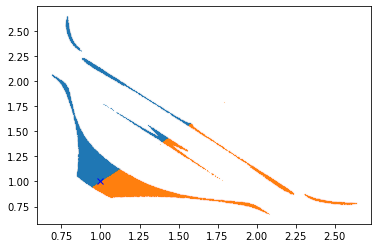

In [10]:
def binData(tags, data, ref_bins):
    for tag in tags:
        m12 = data[tag]["sig_m12"]
        m13 = data[tag]["sig_m13"]
        if tag=="Kspipi":
            m12_tag = data[tag]["tag_m12"]
            m13_tag = data[tag]["tag_m13"]
            bins = []
            for i in range(len(m12)):
                _bin = getBin(m12[i], m13[i], ref_bins)
                bins.append(_bin)
            data[tag].insert(len(data[tag].keys()), "bin_sig", bins, True)
            tag_bins = []
            for i in range(len(m12_tag)):
                _bin = getBin(m12_tag[i], m13_tag[i], ref_bins)
                print(f"At {i}% binning")
                tag_bins.append(_bin)
            data[tag].insert(len(data[tag].keys()), "bin_tag", tag_bins, True)

        
        else : 
            bins = []
            for i in range(len(m12)):
                _bin = getBin(m12[i], m13[i], ref_bins)
                print(f"At {i}% binning")
                bins.append(_bin)
            
            data[tag].insert(0, "bin", bins, True)


    return data

#print(ref_bins)
#print(data)
b = getBin(1,1,ref_bins)
print(b)
f,a=plt.subplots(1,1)
a.plot(1,1,marker="x",color="blue")
df_Bin_plus = equalBinning(refDD, abs(b), 1)
df_Bin_minus = equalBinning(refDD, 9-abs(b), -1)
xp, yp, ddp = df_Bin_plus.T.values
xm, ym, ddm = df_Bin_minus.T.values
a.scatter(xp,yp, s=0.01, marker="x")
a.scatter(xm,ym, s=0.01, marker="x")
print(b)

#binned_Data = binData(list(data.keys()), data, ref_bins)

If you run this code (uncomment the last line), you will find that it takes quite a long time. Fortunately, I've already binned this data and saved it into a `pickle` file so we can just load that instead.


In [14]:
binned_data = {}
for tag in data:
    binned_data[tag] = pd.read_pickle(f"{tag}_data.pkl")
print(binned_Data)
#for tag in binned_Data:
#    df = binned_Data[tag]
#    df.to_pickle(f"{tag}_data.pkl")


{'KK':       bin   sig_m12   sig_m13
0      -1  2.528499  0.705363
1       1  0.780972  1.276463
2      -2  1.127792  0.809603
3       2  0.644745  2.731115
4       1  0.760000  2.264633
...   ...       ...       ...
2523   -7  2.732898  0.861259
2524   -8  2.755401  0.821125
2525   -1  2.504515  0.710276
2526   -1  2.691892  0.781867
2527    4  0.869915  1.092934

[2528 rows x 3 columns], 'Kspi0':       bin   sig_m12   sig_m13
0      -5  1.236443  1.049986
1      -4  1.048282  0.877797
2       1  0.780972  1.276463
3       8  0.802127  2.762997
4      -2  1.127792  0.809603
...   ...       ...       ...
1720    2  0.693501  2.874300
1721   -2  2.420555  0.771884
1722   -2  1.852176  0.750892
1723    4  0.913453  1.067202
1724    4  0.983332  1.006369

[1725 rows x 3 columns], 'Kppim':        bin   sig_m12   sig_m13
0        1  0.780972  1.276463
1        8  0.802127  2.762997
2        2  0.644745  2.731115
3        1  0.760000  2.264633
4        2  0.715103  2.826325
...    ...       

Now we can easily get the individual yields, $N_i$, per bin for each type of $D^0 \to K_S^0 \pi^+ \pi^-$ decay we have. All we need to do is count all of the entries with the bin $i$. In the case of $D \to K_S^0 \pi^+ \pi^-$ v.s. $D^0 \to K_S^0 \pi^+ \pi^-$ we just measure the number of events on "signal" side bin $i$ and "tag" side $j$.

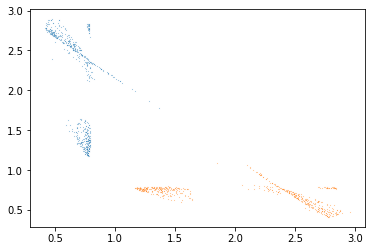

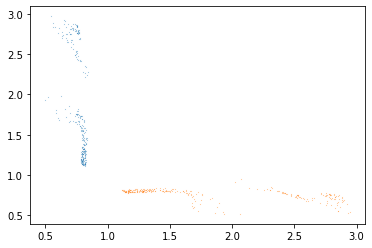

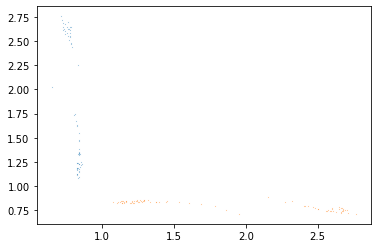

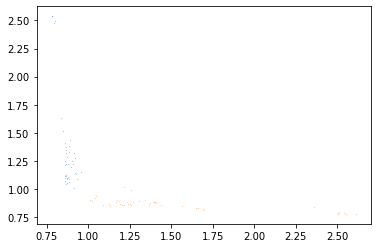

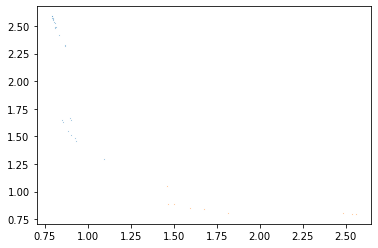

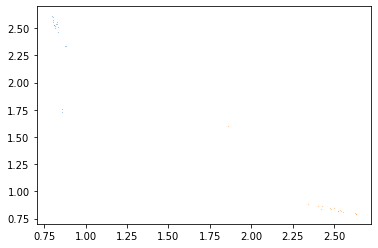

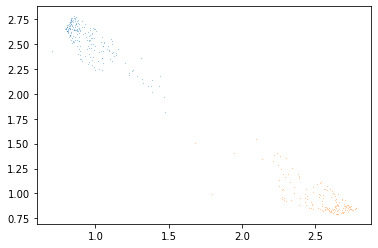

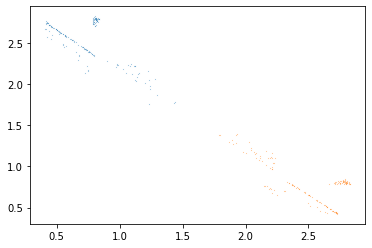

In [25]:
def getNi(tag, i, data):
    df = data[tag]
    if tag!="Kspipi":

        cond = df["bin"]==i
        return len(df[ cond ])
    else :
        cond = df["bin_sig"]==i
        return len(df [cond] )


def getMij(i, j, data):
    df = data["Kspipi"]
    cond_sig = df["bin_sig"]==i
    cond_tag = df["bin_tag"]==j
    return len(df[cond_sig]) + len(df[cond_tag])



N = {}
for tag in "KK Kspi0 Kppim Bp2Dhp Bm2Dhm".split():
    N_tag = {}
    for i in range(1,9):
        N_tag[f"{i}"]  = getNi(tag, i, binned_data)
        N_tag[f"{-i}"] = getNi(tag, -i, binned_data) 
    N[tag] = N_tag
    


    
M = {}

for i in range(1,9):
    for j in range(1,9):
        M[f"{i}{j}"] = getMij(i, j, binned_data) 
        M[f"{-i}{j}"] = getMij(-i, j, binned_data)
        M[f"{i}{-j}"] = getMij(i, -j, binned_data)
        M[f"{-i}{-j}"] = getMij(-i, -j, binned_data)

        
for i in range(1,9):
    df = binned_data["KK"]
    condP = df["bin"]==i
    condM = df["bin"]==-i
    dfP = df[condP]
    dfM = df[condM]
    xP = dfP["sig_m12"]
    yP = dfP["sig_m13"]
    xM = dfM["sig_m12"]
    yM = dfM["sig_m13"]
    f,a=plt.subplots(1,1)
    a.scatter(xP,yP, s=0.01, marker="x")
    a.scatter(xM,yM, s=0.01, marker="x")

Let's consider the $\psi(3770)$ amplitude and its squared magnitude ($\propto$ probability)
\begin{equation}
\psi = AB - CD 
\end{equation}
\begin{equation}
|\psi|^2 = |A|^2 |B|^2 + |C|^2 |D|^2 - 2 |A||B||C||D| \cos(\Delta\delta_{AC} - \Delta\delta_{BD})
\end{equation}

So for each pair of bins we have
\begin{equation}
|\psi|_{ij}^2 = |A|^2_i |B|^2_j + |C|^2_i |D|^2_j - 2 |A|_i|B|_j|C|_i|D|_j (c_i^{AC} c_j^{BD} + s_i^{AC} s_j^{BD})
\end{equation}

We can identify each of the magnitudes with the fractions $F_{\pm i}$ for $D^0 (+i)$ and $\bar{D}^0 (-i)$ instead
\begin{equation}
|\psi|_{ij}^2 =  k (F_{i} F_{-j} + F_{-i} F_{j} - 2 \sqrt{ F_{i} F_{-i} F_{j} F_{-j} } (c_i^{AC} c_j^{BD} + s_i^{AC} s_j^{BD}))
\end{equation}

In the case where we aren't interested in the bin pair (i.e. we sum over $j$) then we have the expected density $n_i$ for a particular tag of $CP=\pm$ we have
\begin{equation}
n_i = k (F_{i} F_{-j} + F_{-i} \mp 2 \sqrt{F_{i} F_{-i}} c_i^{AC})
\end{equation}

where we can obtain $k$ by just normalising the $\sum RHS_i = 1$. 
So the expected yield for a particular tag is then

\begin{equation}
\begin{split}
N_i^{\pm} &= k N^{\pm}_\text{total} (F_{i} F_{-j} + F_{-i} \mp 2 \sqrt{F_{i} F_{-i}} c_i^{AC}) \\
          &= N^{\pm}_\text{total} \frac{F_{i} F_{-j} + F_{-i} \mp 2 \sqrt{F_{i} F_{-i}} c_i}{\sum_i F_{i} F_{-j} + F_{-i} \mp 2 \sqrt{F_{i} F_{-i}} c_i}
          \end{split}
\end{equation}



In [18]:
def F(i):
    FSum = 0
    for j in range(1,9):
        if i>0:
            FSum += N["Kppim"][f"{j}"]
        else :
            FSum += N["Kppim"][f"{-j}"]   
    if i>0:
        return N["Kppim"][f"{i}"]/FSum
    else :
        return N["Kppim"][f"{-i}"]/FSum

print(F(2))


    

0.24547215496368038


In [19]:
def eCP(i, c, CP):
    eCPSum=0
    for j in range(1,9):
        eCPSum+=(F(j) + F(-j) - 2*CP*c[f"{j}"]*(F(j)*F(-j))**0.5)/2
    return 0.5*(F(i) + F(-i) - 2*CP*c[f"{i}"]*(F(i)*F(-i))**0.5)/eCPSum

To fit for $c_i$ with the $CP^\pm$ tag, we fit a Poisson distribution $P(x |\mu)$ with the expected yield as $\mu$ and the real yield as $x$.

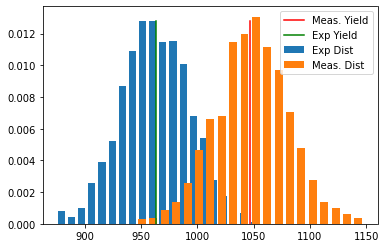

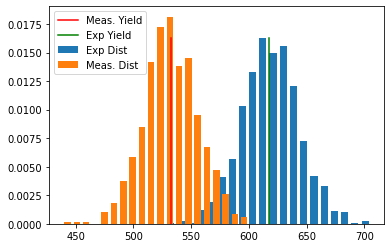

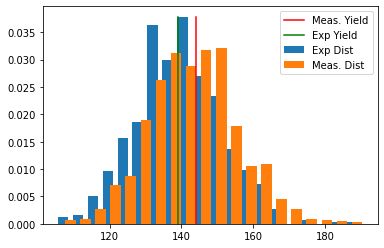

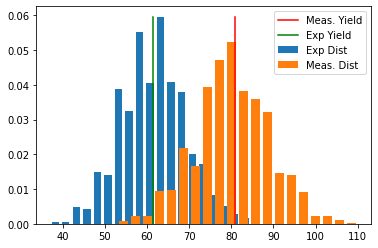

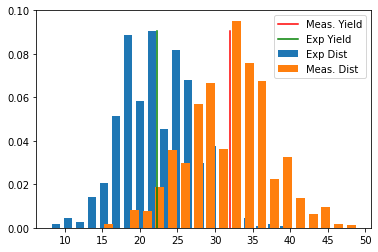

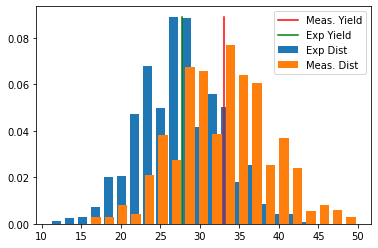

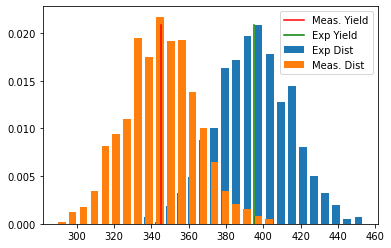

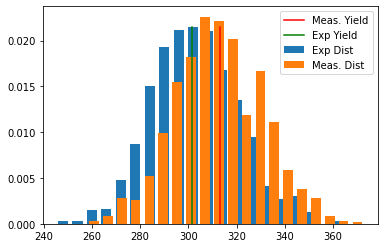

In [20]:
KK_Sum = 0
for i in range(1,9):
    KK_Sum += N["KK"][f"{i}"]+N["KK"][f"{-i}"]


for i in range(1,9):
    mu = eCP(i, ci, 1)*KK_Sum
    
    f, a = plt.subplots(1,1)
    x = np.random.poisson(mu, 1000)
    n, b = np.histogram(x, bins=20, density=True)
    c = 0.5*(b[1:] + b[:-1])
    w = 0.7*(c[1] - c[0])
    xm = N["KK"][f"{i}"]+N["KK"][f"{-i}"]
    ym = max(n)
    
    x0 = np.random.poisson(xm, 1000)
    n0, b0 = np.histogram(x0, bins=20, density=True)
    c0 = 0.5*(b0[1:] + b0[:-1])
    w0 = 0.7*(c0[1] - c0[0])
    
    
    a.bar(c, n, width=w, label=f"Exp Dist")
    a.bar(c0, n0, width=w0, label=f"Meas. Dist")
    a.plot([xm,xm], [0,ym], color="red", label="Meas. Yield")
    a.plot([mu,mu], [0,ym], color="green", label="Exp Yield")
    a.legend()
    
    
    

In [23]:
def nllCP(c1,c2,c3,c4,c5,c6,c7,c8):
    c = {"1":c1,
        "2":c2,
        "3":c3,
        "4":c4,
        "5":c5,
        "6":c6,
        "7":c7,
        "8":c8,}
    nll = 0
    for i in range(1,9):
        xPlus = N["KK"][f"{i}"] + N["KK"][f"{-i}"]
        muPlus = eCP(i, c, 1)
        xMinus = N["Kspi0"][f"{i}"] + N["Kspi0"][f"{-i}"]
        muMinus = eCP(i, c, -1)
        nll += -2 * scipy.stats.poisson(muPlus).logpmf(xPlus)
        nll += -2 * scipy.stats.poisson(muMinus).logpmf(xMinus)
    return nll

mCP = iminuit.Minuit(nllCP)
mCP.print_level=3
resCP = mCP.migrad()
print(resCP)
resMinosCP = mCP.minos()

<ipython-input-23-9379474718d7>:20: InitialParamWarning: Parameter c1 does not have neither initial value nor limits.
  mCP = iminuit.Minuit(nllCP)
<ipython-input-23-9379474718d7>:20: InitialParamWarning: Parameter c2 does not have neither initial value nor limits.
  mCP = iminuit.Minuit(nllCP)
<ipython-input-23-9379474718d7>:20: InitialParamWarning: Parameter c3 does not have neither initial value nor limits.
  mCP = iminuit.Minuit(nllCP)
<ipython-input-23-9379474718d7>:20: InitialParamWarning: Parameter c4 does not have neither initial value nor limits.
  mCP = iminuit.Minuit(nllCP)
<ipython-input-23-9379474718d7>:20: InitialParamWarning: Parameter c5 does not have neither initial value nor limits.
  mCP = iminuit.Minuit(nllCP)
<ipython-input-23-9379474718d7>:20: InitialParamWarning: Parameter c6 does not have neither initial value nor limits.
  mCP = iminuit.Minuit(nllCP)
<ipython-input-23-9379474718d7>:20: InitialParamWarning: Parameter c7 does not have neither initial value nor li

------------------------------------------------------------------
| FCN = 5.695e+04               |     Ncalls=206 (206 total)     |
| EDM = 0.0001 (Goal: 0.0002)   |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
------------------------------------------------------------------
| FCN = 5.695e+04               |     Ncalls=206 (206 total)     |
| EDM = 0.0001 (Goal: 0.0002)   |            up = 1.0         

In [53]:
cs = mCP.params
cFit = {}
ecFit = {}
for _c in cs:
    name = _c.name.split('c')[-1]
    value = _c.value
    err = _c.error
    cFit[name] = value
    ecFit[name] = err
    
pullC = {}
for key in cFit:
    pull = (cFit[key] - ci[key])/ecFit[key]
    pullC[key] = pull

print(ci)
print(cFit)
print(pullC)

{'1': -0.8953307358368806, '2': -0.37425233932400453, '3': 0.3005885943363641, '4': 0.9484870400765878, '5': 0.9317279163728674, '6': 0.41059836642596353, '7': -0.48492993807590984, '8': -0.9043300436820839}
{'1': -0.5881921988373908, '2': 0.12844363548375387, '3': 0.4351319127659291, '4': 0.9450082387575249, '5': 0.8609529874554448, '6': 0.4488291615073008, '7': 0.021771234433431555, '8': -0.5386913917300123}
{'1': 3.892640912216585, '2': 5.458868865503813, '3': 1.2767221087393117, '4': -0.04765100256105441, '5': -0.5980200749332383, '6': 0.22023246273611716, '7': 4.9668095482114625, '8': 3.5666997392512765}


<ipython-input-58-2458156959f8>:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f, a = plt.subplots(1,1)


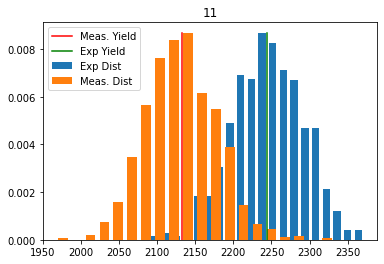

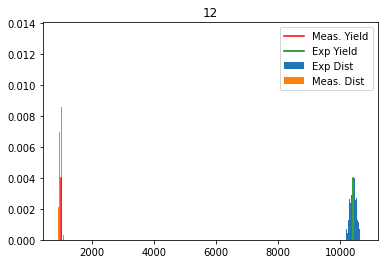

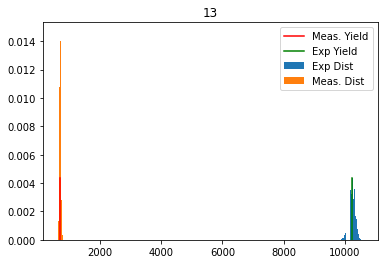

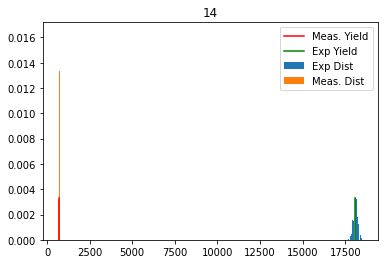

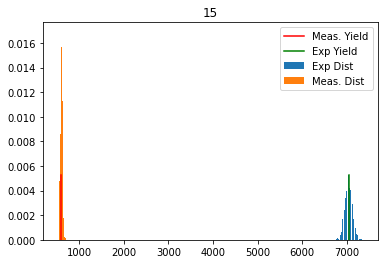

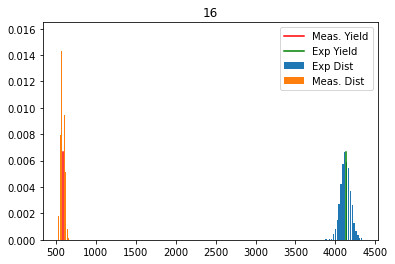

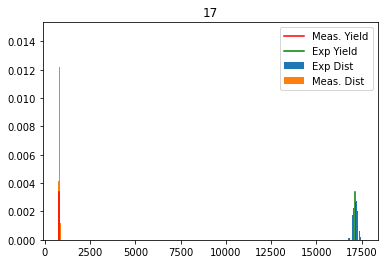

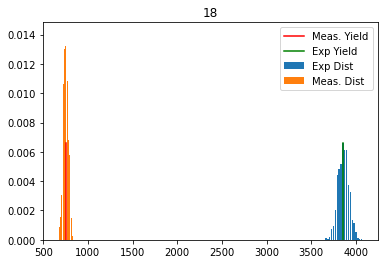

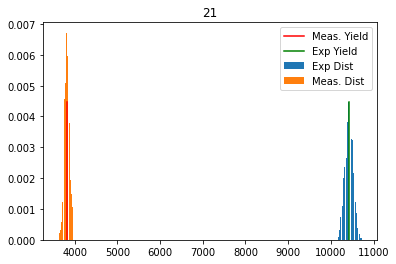

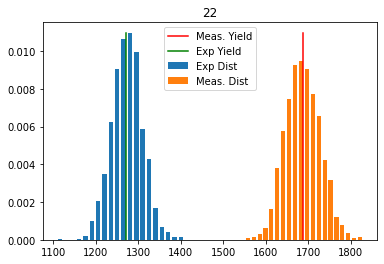

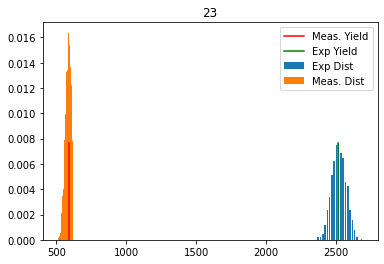

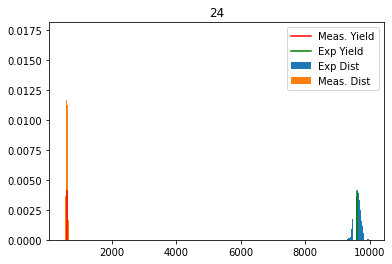

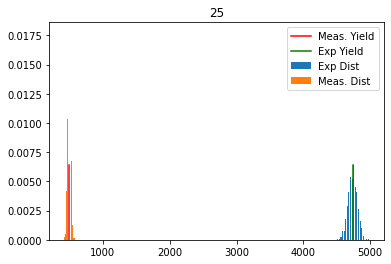

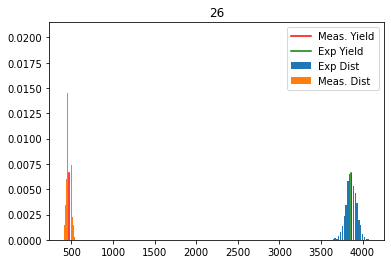

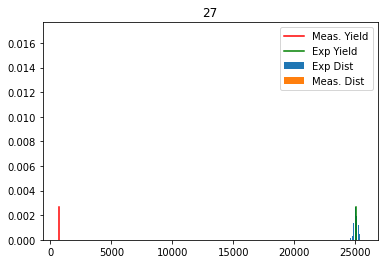

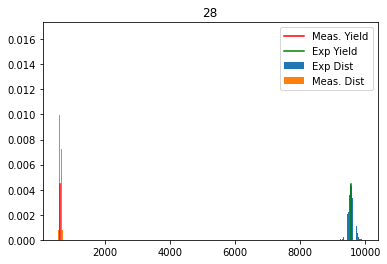

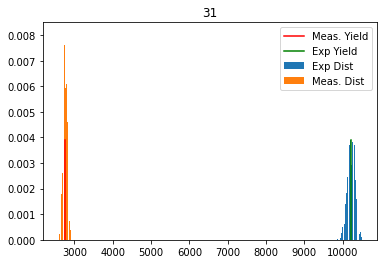

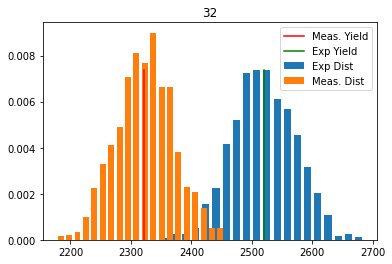

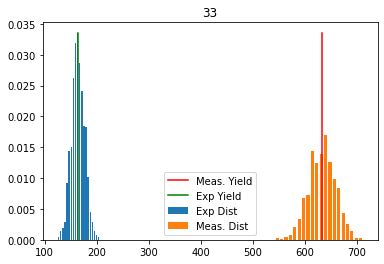

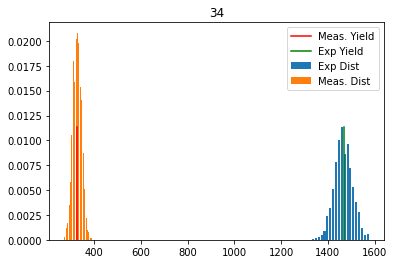

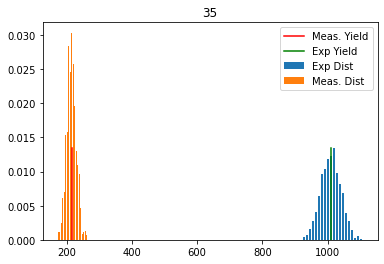

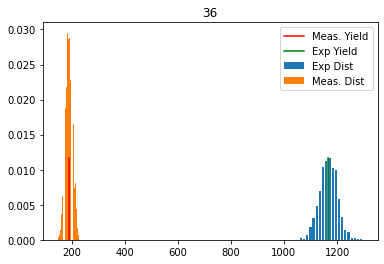

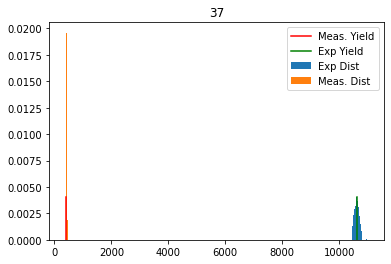

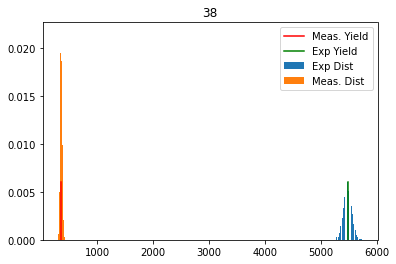

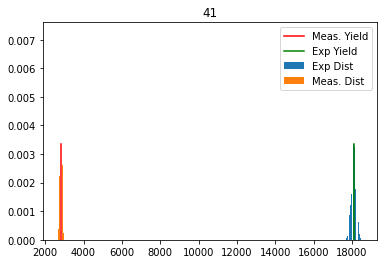

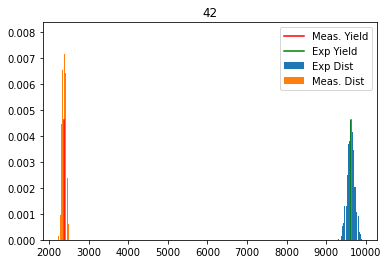

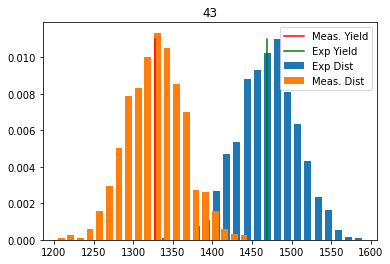

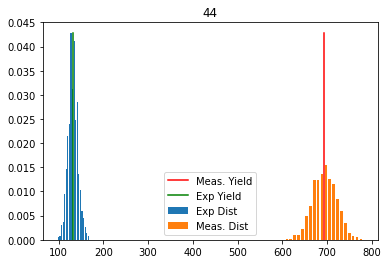

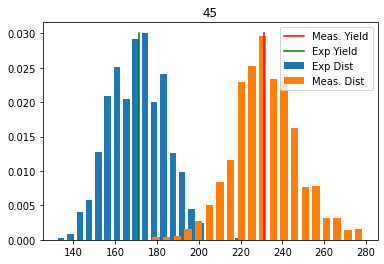

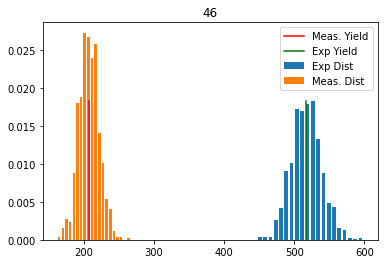

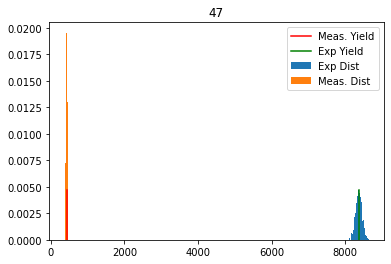

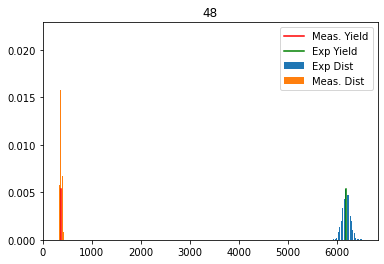

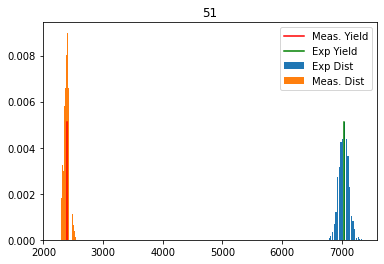

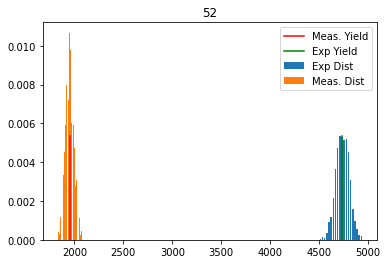

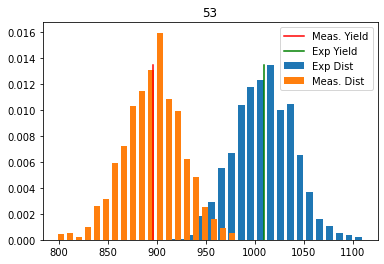

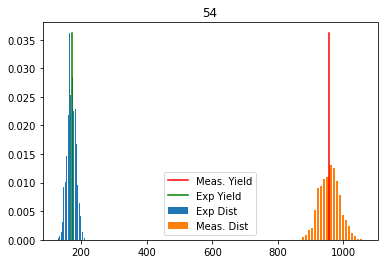

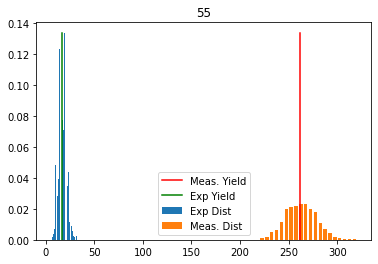

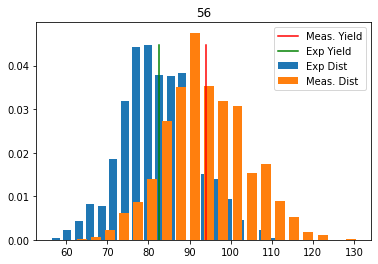

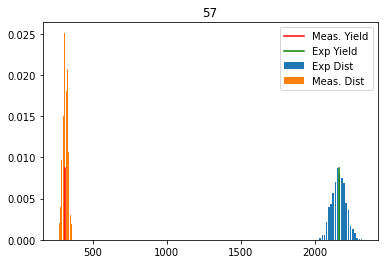

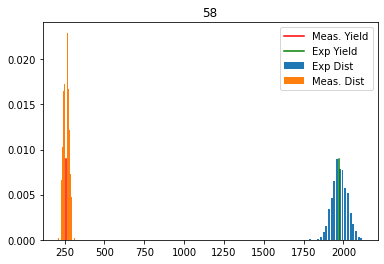

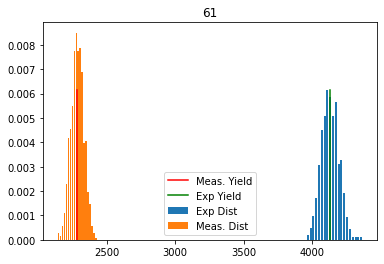

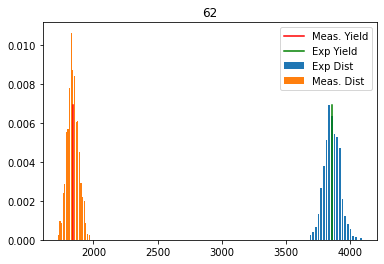

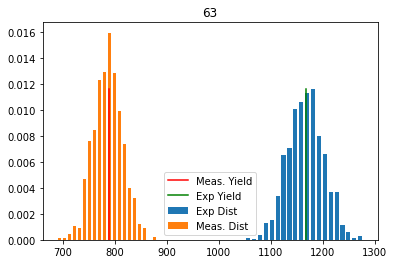

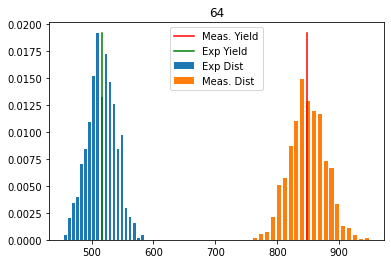

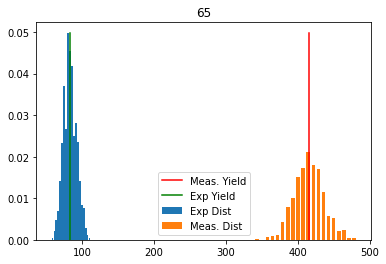

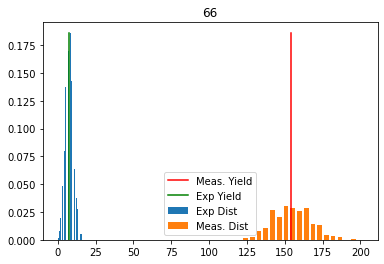

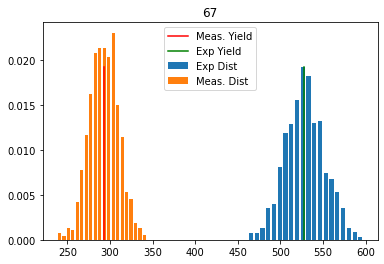

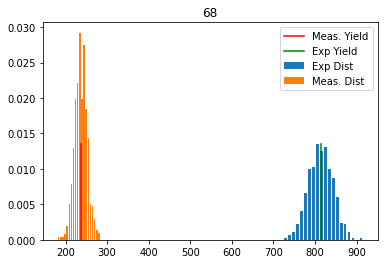

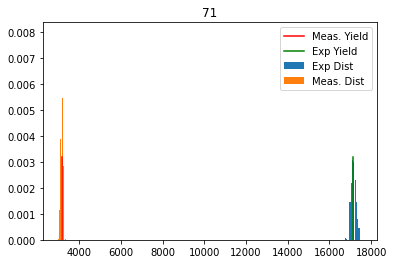

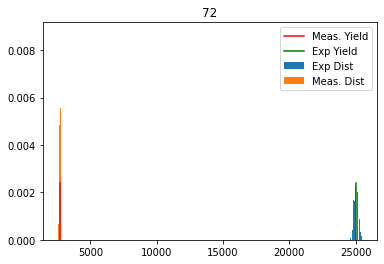

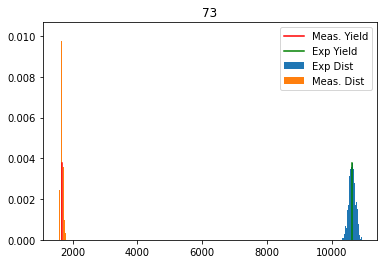

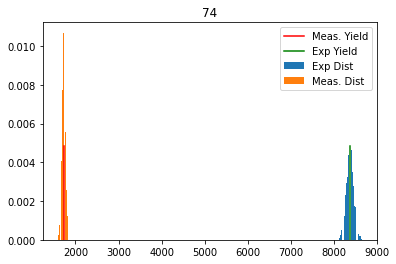

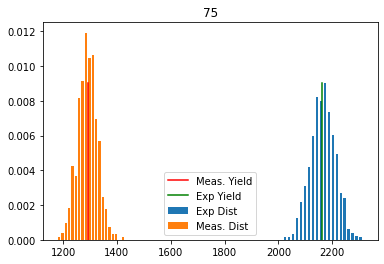

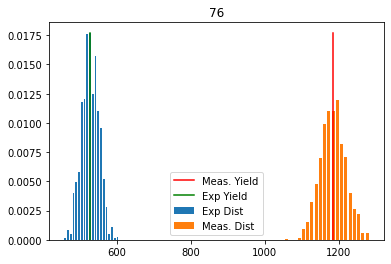

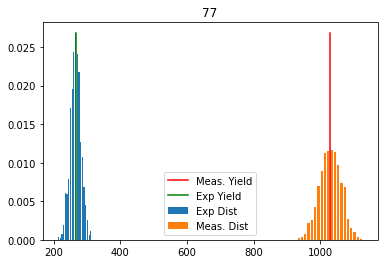

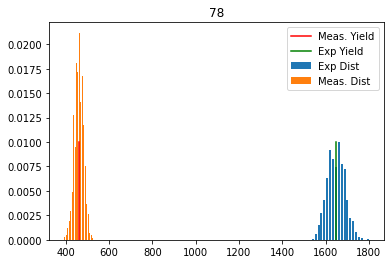

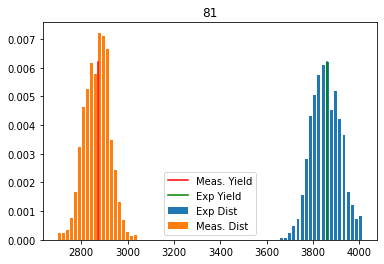

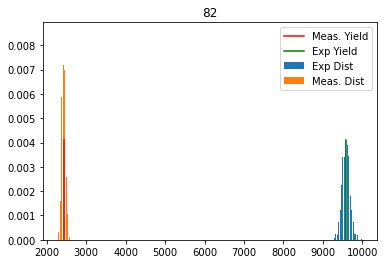

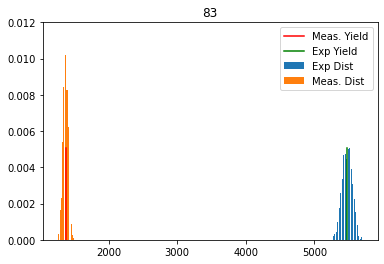

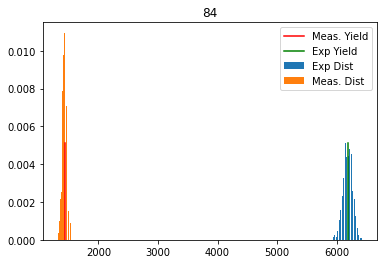

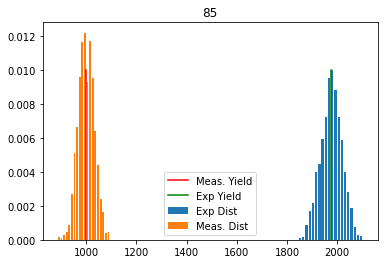

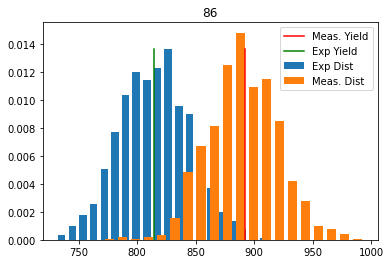

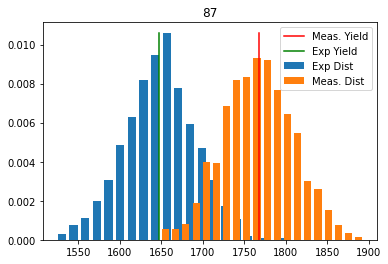

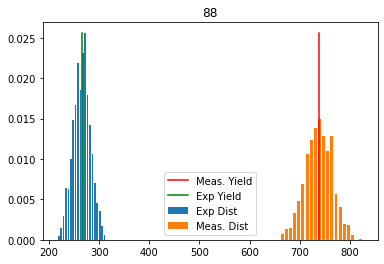

In [58]:
def eDT(i,j,c,s):
    eDTSum=0
    for k in range(1,9):
        for l in range(1,9):
            eDTSum+=(F(k)*F(-l) + F(-k)*F(l) - 2*(c[f"{k}"]*c[f"{l}"] + s[f"{k}"]*s[f"{l}"] )*(F(k)*F(-k)*F(l)*F(-l))**0.5)/2
    return (F(i)*F(-j) + F(-i)*F(j) - 2*(c[f"{i}"]*c[f"{j}"] + s[f"{i}"]*s[f"{j}"] )*(F(i)*F(-i)*F(j)*F(-j))**0.5)/2

DT_Sum = 0
for i in range(1,9):
    for j in range(1,9):
        if i>j:
            DT_Sum += M[f"{i}{j}"]+M[f"{j}{i}"]+M[f"{-i}{j}"]+M[f"{j}{-i}"]+M[f"{i}{-j}"]+M[f"{-j}{i}"]+M[f"{-i}{-j}"]+M[f"{-j}{-i}"]
        #M[f"{i}{j}"]+M[f"{-i}{-j}"]
        elif i==j:
            DT_Sum += M[f"{i}{j}"]+M[f"{-i}{j}"]+M[f"{i}{-j}"]+M[f"{-i}{-j}"]


for i in range(1,9):
    for j in range(1,9):

        mu = eDT(i,j, ci, si)*DT_Sum

        f, a = plt.subplots(1,1)
        x = np.random.poisson(mu, 1000)
        n, b = np.histogram(x, bins=20, density=True)
        c = 0.5*(b[1:] + b[:-1])
        w = 0.7*(c[1] - c[0])
        xm = M[f"{i}{j}"]+M[f"{j}{i}"]
        if i>j:
            xm = M[f"{i}{j}"]+M[f"{j}{i}"]+M[f"{-i}{j}"]+M[f"{j}{-i}"]+M[f"{i}{-j}"]+M[f"{-j}{i}"]+M[f"{-i}{-j}"]+M[f"{-j}{-i}"]
        #M[f"{i}{j}"]+M[f"{-i}{-j}"]
        elif i==j:
            xm = M[f"{i}{j}"]+M[f"{-i}{j}"]+M[f"{i}{-j}"]+M[f"{-i}{-j}"]

 
        ym = max(n)

        x0 = np.random.poisson(xm, 1000)
        n0, b0 = np.histogram(x0, bins=20, density=True)
        c0 = 0.5*(b0[1:] + b0[:-1])
        w0 = 0.7*(c0[1] - c0[0])


        a.bar(c, n, width=w, label=f"Exp Dist")
        a.bar(c0, n0, width=w0, label=f"Meas. Dist")
        a.plot([xm,xm], [0,ym], color="red", label="Meas. Yield")
        a.plot([mu,mu], [0,ym], color="green", label="Exp Yield")
        a.set_title(f"{i}{j}")
        a.legend()

